In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

# Quick fits for TESS light curves

In this tutorial, we will fit the TESS light curve for a known transiting planet.
While the :ref:`tess` tutorial goes through the full details of an end-to-end fit, this tutorial is significantly faster to run and it can give pretty excellent results depending on your goals.
Some of the main differences are:

1. We start from the light curve rather than doing the photometry ourselves. This should pretty much always be fine unless you have a very bright, faint, or crowded target.
2. We assume a circluar orbit, but as you'll see later, we can approximately relax this assumption later.
3. We only fit the data near transit. In many cases this will be just fine, but if you have predictable stellar variability (like coherent rotation) then you might do better fitting more data.

We'll fit the planet in the HD 118203 (TIC 286923464) system that was found to transit by [Pepper et al. (2019)](https://arxiv.org/abs/1911.05150) because it is on an eccentric orbit so assumption #2 above is not valid.

First, let's download the TESS light curve using [lightkurve](https://docs.lightkurve.org/):

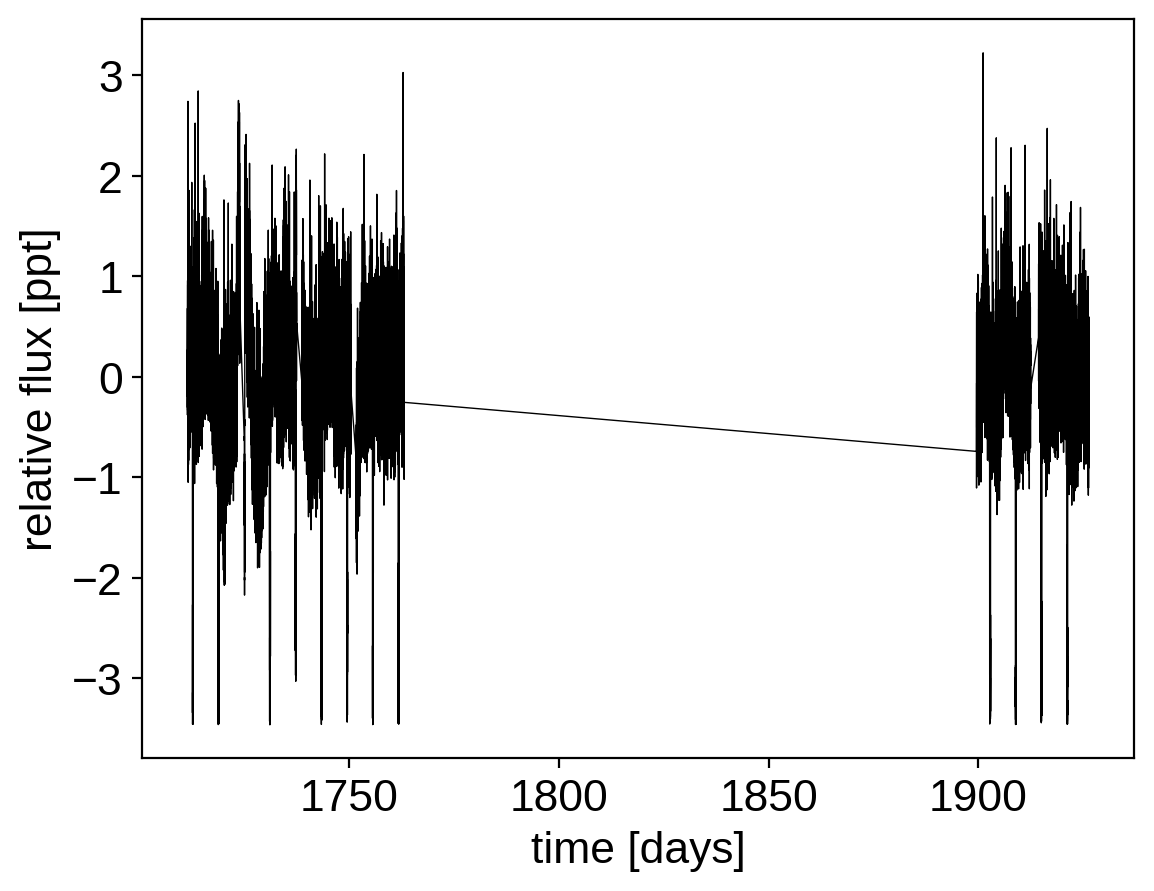

In [3]:
import numpy as np
import lightkurve as lk
import matplotlib.pyplot as plt

lcfs = lk.search_lightcurvefile("TIC 286923464", mission="TESS").download_all()
lc = lcfs.PDCSAP_FLUX.stitch()
lc = lc.remove_nans().remove_outliers()

x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray(1e3 * (lc.flux - 1), dtype=np.float64)
yerr = np.ascontiguousarray(1e3 * lc.flux_err, dtype=np.float64)

texp = np.min(np.diff(x))

plt.plot(x, y, "k", linewidth=0.5)
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]");

Then, find the period, phase and depth of the transit using box least squares:

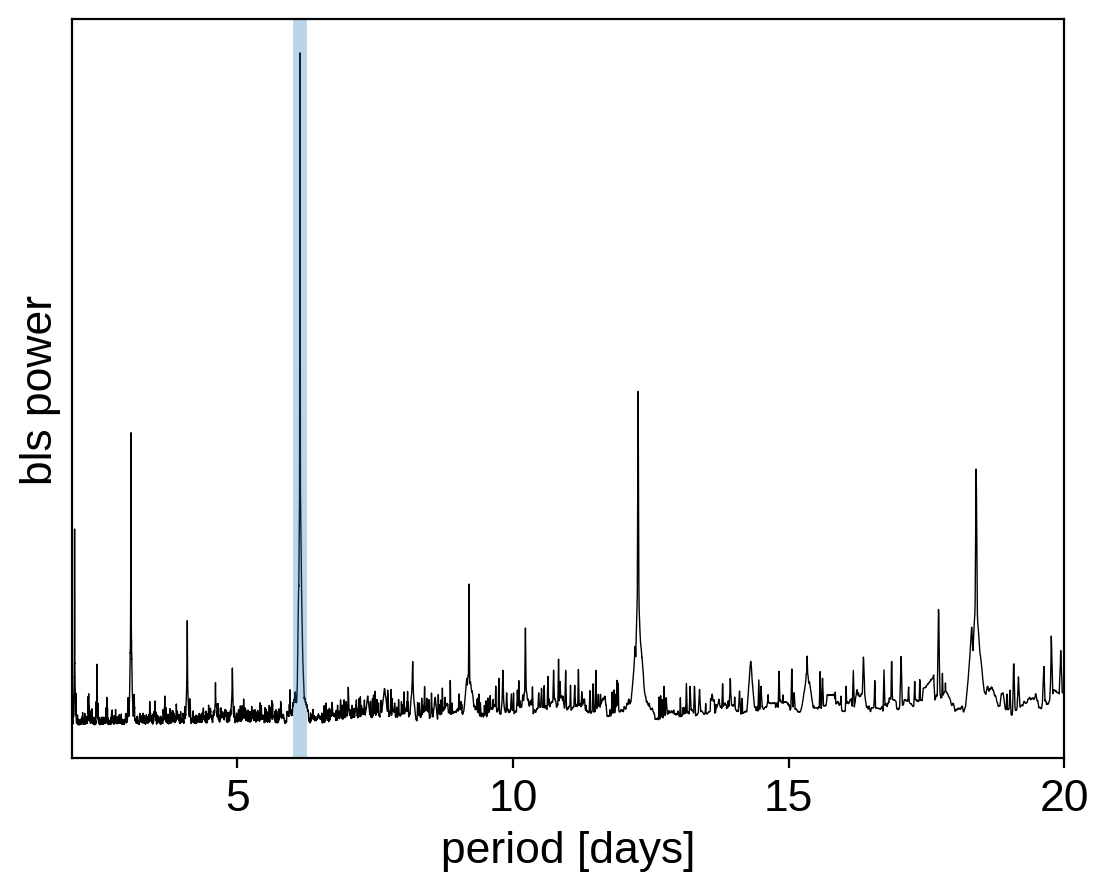

In [4]:
import exoplanet as xo

pg = xo.estimators.bls_estimator(x, y, yerr, min_period=2, max_period=20)

peak = pg["peak_info"]
period_guess = peak["period"]
t0_guess = peak["transit_time"]
depth_guess = peak["depth"]

plt.plot(pg["bls"].period, pg["bls"].power, "k", linewidth=0.5)
plt.axvline(period_guess, alpha=0.3, linewidth=5)
plt.xlabel("period [days]")
plt.ylabel("bls power")
plt.yticks([])
plt.xlim(pg["bls"].period.min(), pg["bls"].period.max());

Then, for efficiency purposes, let's extract just the data within 0.25 days of the transits:

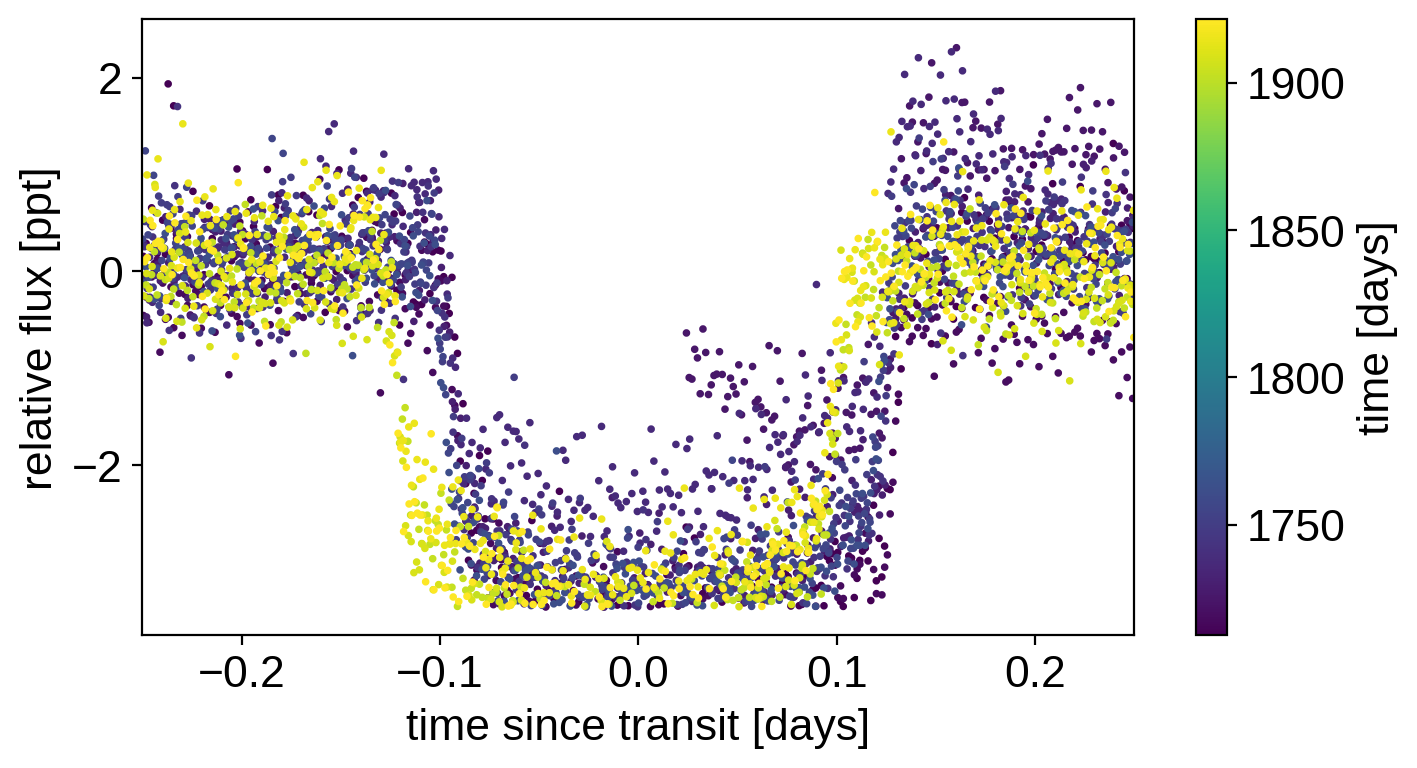

In [5]:
transit_mask = (
    np.abs((x - t0_guess + 0.5 * period_guess) % period_guess - 0.5 * period_guess)
    < 0.25
)
x = np.ascontiguousarray(x[transit_mask])
y = np.ascontiguousarray(y[transit_mask])
yerr = np.ascontiguousarray(yerr[transit_mask])

plt.figure(figsize=(8, 4))
x_fold = (x - t0_guess + 0.5 * period_guess) % period_guess - 0.5 * period_guess
plt.scatter(x_fold, y, c=x, s=3)
plt.xlabel("time since transit [days]")
plt.ylabel("relative flux [ppt]")
plt.colorbar(label="time [days]")
plt.xlim(-0.25, 0.25);

That looks a little janky, but it's good enough for now.

## The probabilistic model

Here's how we set up the PyMC3 model in this case:

In [6]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:

    # Stellar parameters
    mean = pm.Normal("mean", mu=0.0, sigma=10.0)
    u = xo.distributions.QuadLimbDark("u")
    star_params = [mean, u]

    # Gaussian process noise model
    sigma = pm.InverseGamma("sigma", alpha=3.0, beta=2 * np.median(yerr))
    log_Sw4 = pm.Normal("log_Sw4", mu=0.0, sigma=10.0)
    log_w0 = pm.Normal("log_w0", mu=np.log(2 * np.pi / 10.0), sigma=10.0)
    kernel = xo.gp.terms.SHOTerm(log_Sw4=log_Sw4, log_w0=log_w0, Q=1.0 / 3)
    noise_params = [sigma, log_Sw4, log_w0]

    # Planet parameters
    log_ror = pm.Normal("log_ror", mu=0.5 * np.log(depth_guess * 1e-3), sigma=10.0)
    ror = pm.Deterministic("ror", tt.exp(log_ror))

    # Orbital parameters
    log_period = pm.Normal("log_period", mu=np.log(period_guess), sigma=1.0)
    t0 = pm.Normal("t0", mu=t0_guess, sigma=1.0)
    log_dur = pm.Normal("log_dur", mu=np.log(0.1), sigma=10.0)
    b = xo.distributions.ImpactParameter("b", ror=ror)

    period = pm.Deterministic("period", tt.exp(log_period))
    dur = pm.Deterministic("dur", tt.exp(log_dur))

    # Set up the orbit
    orbit = xo.orbits.KeplerianOrbit(period=period, duration=dur, t0=t0, b=b)

    # We're going to track the implied density for reasons that will become clear later
    pm.Deterministic("rho_circ", orbit.rho_star)

    # Set up the mean transit model
    star = xo.LimbDarkLightCurve(u)

    def lc_model(t):
        return mean + 1e3 * tt.sum(
            star.get_light_curve(orbit=orbit, r=ror, t=t), axis=-1
        )

    # Finally the GP observation model
    gp = xo.gp.GP(kernel, x, yerr ** 2 + sigma ** 2, mean=lc_model)
    gp.marginal("obs", observed=y)

    # Double check that everything looks good - we shouldn't see any NaNs!
    print(model.check_test_point())

    # Optimize the model
    map_soln = model.test_point
    map_soln = xo.optimize(map_soln, [sigma])
    map_soln = xo.optimize(map_soln, [log_ror, b, log_dur])
    map_soln = xo.optimize(map_soln, noise_params)
    map_soln = xo.optimize(map_soln, star_params)
    map_soln = xo.optimize(map_soln)

mean                   -3.22
u_quadlimbdark__       -2.77
sigma_log__            -0.53
log_Sw4                -3.22
log_w0                 -3.22
log_ror                -3.22
log_period             -0.92
t0                     -0.92
log_dur                -3.22
b_impact__             -1.39
obs                -24037.81
Name: Log-probability of test_point, dtype: float64


optimizing logp for variables: [sigma]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-2.406045e+04]

1it [00:00, 148.19it/s, logp=-2.406045e+04]

2it [00:00, 204.24it/s, logp=-2.406045e+04]

3it [00:00, 231.48it/s, logp=-1.258695e+04]

4it [00:00, 257.67it/s, logp=-1.585485e+04]

5it [00:00, 277.09it/s, logp=-9.500988e+03]

6it [00:00, 294.90it/s, logp=-2.909448e+04]

7it [00:00, 309.17it/s, logp=-6.974327e+03]

8it [00:00, 321.29it/s, logp=-2.585298e+04]

9it [00:00, 334.60it/s, logp=-6.686286e+03]

10it [00:00, 345.39it/s, logp=-6.529571e+03]

11it [00:00, 354.50it/s, logp=-6.493212e+03]

12it [00:00, 363.52it/s, logp=-6.491903e+03]

13it [00:00, 370.52it/s, logp=-6.491897e+03]

14it [00:00, 377.74it/s, logp=-6.491897e+03]

15it [00:00, 382.74it/s, logp=-6.491897e+03]

16it [00:01,  9.51it/s, logp=-6.491897e+03] 


message: Optimization terminated successfully.
logp: -24060.450789871506 -> -6491.896832790021


optimizing logp for variables: [log_dur, b, log_ror]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-6.491897e+03]

1it [00:00, 179.70it/s, logp=-6.491897e+03]

2it [00:00, 258.50it/s, logp=-6.491897e+03]

3it [00:00, 278.18it/s, logp=-6.103838e+03]

4it [00:00, 294.77it/s, logp=-6.845120e+03]

5it [00:00, 318.20it/s, logp=-6.020253e+03]

6it [00:00, 334.31it/s, logp=-5.856041e+03]

7it [00:00, 342.90it/s, logp=-5.514087e+03]

8it [00:00, 347.03it/s, logp=-7.047286e+03]

9it [00:00, 352.75it/s, logp=-5.274320e+03]

10it [00:00, 358.39it/s, logp=-5.010335e+03]

11it [00:00, 365.76it/s, logp=-5.269934e+03]

12it [00:00, 372.51it/s, logp=-4.933138e+03]

13it [00:00, 363.24it/s, logp=-4.929130e+03]

14it [00:00, 355.62it/s, logp=-4.926426e+03]

15it [00:00, 352.51it/s, logp=-4.926413e+03]

16it [00:00, 351.59it/s, logp=-4.926412e+03]

17it [00:00, 345.87it/s, logp=-4.926412e+03]

18it [00:00, 342.63it/s, logp=-4.926412e+03]

19it [00:00, 339.02it/s, logp=-4.926412e+03]

20it [00:00, 337.30it/s, logp=-4.926412e+03]

21it [00:00, 105.31it/s, logp=-4.926412e+03]


message: Optimization terminated successfully.
logp: -6491.896832790021 -> -4926.412276779751


optimizing logp for variables: [log_w0, log_Sw4, sigma]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-4.926412e+03]

1it [00:00, 75.47it/s, logp=-4.926412e+03]

2it [00:00, 120.74it/s, logp=-4.926412e+03]

3it [00:00, 151.63it/s, logp=-3.498456e+03]

4it [00:00, 173.65it/s, logp=-2.690911e+04]

5it [00:00, 191.60it/s, logp=-3.470034e+03]

6it [00:00, 207.30it/s, logp=-3.414748e+03]

7it [00:00, 223.37it/s, logp=-4.264842e+03]

8it [00:00, 237.60it/s, logp=-2.589067e+03]

9it [00:00, 247.72it/s, logp=-2.461533e+03]

10it [00:00, 254.62it/s, logp=-6.525483e+03]

11it [00:00, 263.02it/s, logp=-2.498025e+03]

12it [00:00, 270.95it/s, logp=-2.372980e+03]

13it [00:00, 278.31it/s, logp=-2.307623e+03]

14it [00:00, 280.39it/s, logp=-4.879708e+03]

15it [00:00, 284.26it/s, logp=-2.307540e+03]

16it [00:00, 289.82it/s, logp=-2.306074e+03]

17it [00:00, 294.10it/s, logp=-2.302955e+03]

18it [00:00, 299.19it/s, logp=-2.290640e+03]

19it [00:00, 303.76it/s, logp=-2.244011e+03]

20it [00:00, 307.42it/s, logp=-2.132040e+03]

21it [00:00, 310.80it/s, logp=-1.967503e+03]

22it [00:00, 313.27it/s, logp=-1.890914e+03]

23it [00:00, 314.76it/s, logp=-1.877392e+03]

24it [00:00, 317.21it/s, logp=-1.873395e+03]

25it [00:00, 319.34it/s, logp=-1.872949e+03]

26it [00:00, 321.93it/s, logp=-1.872913e+03]

27it [00:00, 323.96it/s, logp=-1.872912e+03]

28it [00:00, 325.81it/s, logp=-1.872912e+03]

29it [00:00, 327.95it/s, logp=-1.872912e+03]

30it [00:00, 329.87it/s, logp=-1.872912e+03]

31it [00:00, 331.45it/s, logp=-1.872912e+03]

32it [00:00, 332.95it/s, logp=-1.872912e+03]

33it [00:00, 334.74it/s, logp=-1.872912e+03]

34it [00:00, 334.88it/s, logp=-1.872912e+03]

35it [00:00, 339.37it/s, logp=-1.872912e+03]

35it [00:00, 339.37it/s, logp=-1.872912e+03]

36it [00:00, 339.37it/s, logp=-1.872912e+03]

37it [00:00, 339.37it/s, logp=-1.872912e+03]

38it [00:00, 339.37it/s, logp=-1.872912e+03]

39it [00:00, 339.37it/s, logp=-1.872912e+03]

40it [00:00, 339.37it/s, logp=-1.872912e+03]

41it [00:00, 339.37it/s, logp=-1.872912e+03]

42it [00:00, 339.37it/s, logp=-1.872912e+03]

43it [00:00, 339.37it/s, logp=-1.872912e+03]

44it [00:00, 339.37it/s, logp=-1.872912e+03]

45it [00:00, 339.37it/s, logp=-1.872912e+03]

46it [00:00, 339.37it/s, logp=-1.872912e+03]

47it [00:00, 339.37it/s, logp=-1.872912e+03]

48it [00:00, 339.37it/s, logp=-1.872912e+03]

49it [00:00, 339.37it/s, logp=-1.872912e+03]

50it [00:00, 339.37it/s, logp=-1.872912e+03]

51it [00:00, 339.37it/s, logp=-1.872912e+03]

52it [00:00, 339.37it/s, logp=-1.872912e+03]

53it [00:00, 339.37it/s, logp=-1.872912e+03]

54it [00:00, 339.37it/s, logp=-1.872912e+03]

55it [00:00, 339.37it/s, logp=-1.872912e+03]

56it [00:00, 339.37it/s, logp=-1.872912e+03]

57it [00:00, 339.37it/s, logp=-1.872912e+03]

58it [00:00, 339.37it/s, logp=-1.872912e+03]

59it [00:00, 339.37it/s, logp=-1.872912e+03]

60it [00:00, 339.37it/s, logp=-1.872912e+03]

61it [00:00, 339.37it/s, logp=-1.872912e+03]

62it [00:00, 339.37it/s, logp=-1.872912e+03]

63it [00:00, 339.37it/s, logp=-1.872912e+03]

64it [00:00, 339.37it/s, logp=-1.872912e+03]

65it [00:00, 339.37it/s, logp=-1.872912e+03]

66it [00:00, 339.37it/s, logp=-1.872912e+03]

67it [00:00, 339.37it/s, logp=-1.872912e+03]

68it [00:00, 339.37it/s, logp=-1.872912e+03]

69it [00:00, 339.37it/s, logp=-1.872912e+03]

70it [00:00, 339.37it/s, logp=-1.872912e+03]

71it [00:00, 339.37it/s, logp=-1.872912e+03]

72it [00:00, 339.37it/s, logp=-1.872912e+03]

73it [00:00, 349.78it/s, logp=-1.872912e+03]

73it [00:00, 349.78it/s, logp=-1.872912e+03]

74it [00:00, 349.78it/s, logp=-1.872912e+03]

75it [00:00, 349.78it/s, logp=-1.872912e+03]

76it [00:00, 349.78it/s, logp=-1.872912e+03]

77it [00:00, 349.78it/s, logp=-1.872912e+03]

78it [00:00, 349.78it/s, logp=-1.872912e+03]

79it [00:00, 145.63it/s, logp=-1.872912e+03]


message: Optimization terminated successfully.
logp: -4926.412276779751 -> -1872.9123033179976


optimizing logp for variables: [u, mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-1.872912e+03]

1it [00:00, 171.14it/s, logp=-1.872912e+03]

2it [00:00, 234.08it/s, logp=-1.872912e+03]

3it [00:00, 256.66it/s, logp=-1.966197e+03]

4it [00:00, 279.58it/s, logp=-1.868019e+03]

5it [00:00, 294.26it/s, logp=-1.886594e+03]

6it [00:00, 310.58it/s, logp=-1.867764e+03]

7it [00:00, 322.27it/s, logp=-1.867640e+03]

8it [00:00, 331.49it/s, logp=-1.867588e+03]

9it [00:00, 340.41it/s, logp=-1.867587e+03]

10it [00:00, 347.92it/s, logp=-1.867587e+03]

11it [00:00, 312.80it/s, logp=-1.867587e+03]

12it [00:00, 292.84it/s, logp=-1.867587e+03]

13it [00:00, 76.15it/s, logp=-1.867587e+03] 


message: Optimization terminated successfully.
logp: -1872.9123033179976 -> -1867.58739329712


optimizing logp for variables: [b, log_dur, t0, log_period, log_ror, log_w0, log_Sw4, sigma, u, mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-1.867587e+03]

1it [00:00, 138.52it/s, logp=-1.867587e+03]

2it [00:00, 194.99it/s, logp=-1.867587e+03]

3it [00:00, 219.38it/s, logp=-2.411376e+03]

4it [00:00, 247.62it/s, logp=-2.476389e+03]

5it [00:00, 267.71it/s, logp=-2.295788e+03]

6it [00:00, 281.19it/s, logp=-2.397950e+03]

7it [00:00, 252.89it/s, logp=-2.533392e+03]

8it [00:00, 228.11it/s, logp=-2.141441e+03]

9it [00:00, 217.37it/s, logp=-1.866367e+03]

10it [00:00, 211.55it/s, logp=-1.863947e+03]

11it [00:00, 212.31it/s, logp=-1.855592e+03]

12it [00:00, 213.52it/s, logp=-1.837083e+03]

13it [00:00, 215.80it/s, logp=-1.821468e+03]

14it [00:00, 218.78it/s, logp=-1.818541e+03]

15it [00:00, 223.05it/s, logp=-1.811443e+03]

16it [00:00, 226.41it/s, logp=-1.859700e+03]

17it [00:00, 231.38it/s, logp=-1.810384e+03]

18it [00:00, 234.45it/s, logp=-1.809064e+03]

19it [00:00, 237.56it/s, logp=-1.806820e+03]

20it [00:00, 240.50it/s, logp=-1.803345e+03]

21it [00:00, 243.59it/s, logp=-1.797557e+03]

22it [00:00, 246.36it/s, logp=-1.790903e+03]

23it [00:00, 248.82it/s, logp=-1.777934e+03]

24it [00:00, 251.46it/s, logp=-1.748133e+03]

25it [00:00, 253.98it/s, logp=-1.730666e+03]

26it [00:00, 257.19it/s, logp=-1.717335e+03]

27it [00:00, 265.68it/s, logp=-1.717335e+03]

27it [00:00, 265.68it/s, logp=-1.654028e+03]

28it [00:00, 265.68it/s, logp=-1.624481e+03]

29it [00:00, 265.68it/s, logp=-1.606246e+03]

30it [00:00, 265.68it/s, logp=-1.683617e+03]

31it [00:00, 265.68it/s, logp=-1.591718e+03]

32it [00:00, 265.68it/s, logp=-1.566121e+03]

33it [00:00, 265.68it/s, logp=-1.521184e+03]

34it [00:00, 265.68it/s, logp=-1.462842e+03]

35it [00:00, 265.68it/s, logp=-1.530849e+03]

36it [00:00, 265.68it/s, logp=-1.449961e+03]

37it [00:00, 265.68it/s, logp=-1.429591e+03]

38it [00:00, 265.68it/s, logp=-1.423980e+03]

39it [00:00, 265.68it/s, logp=-1.419108e+03]

40it [00:00, 265.68it/s, logp=-1.417243e+03]

41it [00:00, 265.68it/s, logp=-1.415844e+03]

42it [00:00, 265.68it/s, logp=-1.413513e+03]

43it [00:00, 265.68it/s, logp=-1.409957e+03]

44it [00:00, 265.68it/s, logp=-1.406275e+03]

45it [00:00, 265.68it/s, logp=-1.404060e+03]

46it [00:00, 265.68it/s, logp=-1.401967e+03]

47it [00:00, 265.68it/s, logp=-1.401601e+03]

48it [00:00, 265.68it/s, logp=-1.400763e+03]

49it [00:00, 265.68it/s, logp=-1.400076e+03]

50it [00:00, 265.68it/s, logp=-1.399615e+03]

51it [00:00, 265.68it/s, logp=-1.399116e+03]

52it [00:00, 265.68it/s, logp=-1.398587e+03]

53it [00:00, 265.68it/s, logp=-1.397318e+03]

54it [00:00, 265.68it/s, logp=-1.428522e+03]

55it [00:00, 265.68it/s, logp=-1.397043e+03]

56it [00:00, 265.68it/s, logp=-1.396765e+03]

57it [00:00, 265.68it/s, logp=-1.408881e+03]

58it [00:00, 265.68it/s, logp=-1.396401e+03]

59it [00:00, 277.80it/s, logp=-1.396401e+03]

59it [00:00, 277.80it/s, logp=-1.396141e+03]

60it [00:00, 277.80it/s, logp=-1.394802e+03]

61it [00:00, 277.80it/s, logp=-1.392415e+03]

62it [00:00, 277.80it/s, logp=-1.388223e+03]

63it [00:00, 277.80it/s, logp=-1.382638e+03]

64it [00:00, 277.80it/s, logp=-1.381734e+03]

65it [00:00, 277.80it/s, logp=-1.381647e+03]

66it [00:00, 277.80it/s, logp=-1.381591e+03]

67it [00:00, 277.80it/s, logp=-1.381521e+03]

68it [00:00, 277.80it/s, logp=-1.381480e+03]

69it [00:00, 277.80it/s, logp=-1.381473e+03]

70it [00:00, 277.80it/s, logp=-1.381471e+03]

71it [00:00, 277.80it/s, logp=-1.381470e+03]

72it [00:00, 277.80it/s, logp=-1.381470e+03]

73it [00:00, 277.80it/s, logp=-1.381469e+03]

74it [00:00, 277.80it/s, logp=-1.381469e+03]

75it [00:00, 277.80it/s, logp=-1.381469e+03]

76it [00:00, 277.80it/s, logp=-1.381469e+03]

77it [00:00, 277.80it/s, logp=-1.381469e+03]

78it [00:00, 277.80it/s, logp=-1.381469e+03]

79it [00:00, 277.80it/s, logp=-1.381469e+03]

80it [00:00, 277.80it/s, logp=-1.381469e+03]

81it [00:00, 277.80it/s, logp=-1.381469e+03]

82it [00:00, 277.80it/s, logp=-1.381469e+03]

83it [00:00, 277.80it/s, logp=-1.381469e+03]

84it [00:00, 277.80it/s, logp=-1.381469e+03]

85it [00:00, 277.80it/s, logp=-1.381469e+03]

86it [00:00, 277.80it/s, logp=-1.381469e+03]

87it [00:00, 277.49it/s, logp=-1.381469e+03]

87it [00:00, 277.49it/s, logp=-1.381469e+03]

88it [00:00, 277.49it/s, logp=-1.381469e+03]

89it [00:00, 277.49it/s, logp=-1.381469e+03]

90it [00:00, 277.49it/s, logp=-1.381469e+03]

91it [00:00, 277.49it/s, logp=-1.381469e+03]

92it [00:00, 277.49it/s, logp=-1.381469e+03]

93it [00:00, 277.49it/s, logp=-1.381469e+03]

94it [00:00, 277.49it/s, logp=-1.381469e+03]

95it [00:00, 277.49it/s, logp=-1.381469e+03]

96it [00:00, 277.49it/s, logp=-1.381469e+03]

97it [00:00, 277.49it/s, logp=-1.381469e+03]

98it [00:00, 277.49it/s, logp=-1.381469e+03]

99it [00:00, 277.49it/s, logp=-1.381469e+03]

100it [00:00, 277.49it/s, logp=-1.381469e+03]

101it [00:00, 277.49it/s, logp=-1.381469e+03]

102it [00:00, 277.49it/s, logp=-1.381469e+03]

103it [00:00, 277.49it/s, logp=-1.381469e+03]

104it [00:00, 277.49it/s, logp=-1.381469e+03]

105it [00:00, 277.49it/s, logp=-1.381469e+03]

106it [00:00, 277.49it/s, logp=-1.381469e+03]

107it [00:00, 277.49it/s, logp=-1.381469e+03]

108it [00:00, 277.49it/s, logp=-1.381469e+03]

109it [00:00, 277.49it/s, logp=-1.381469e+03]

110it [00:00, 277.49it/s, logp=-1.381469e+03]

111it [00:00, 277.49it/s, logp=-1.381469e+03]

112it [00:00, 277.49it/s, logp=-1.381469e+03]

113it [00:00, 277.49it/s, logp=-1.381469e+03]

114it [00:00, 277.49it/s, logp=-1.381469e+03]

115it [00:00, 277.49it/s, logp=-1.381469e+03]

116it [00:00, 277.49it/s, logp=-1.381469e+03]

117it [00:00, 277.49it/s, logp=-1.381469e+03]

118it [00:00, 277.49it/s, logp=-1.381469e+03]

119it [00:00, 277.49it/s, logp=-1.381469e+03]

120it [00:00, 277.49it/s, logp=-1.381469e+03]

121it [00:00, 292.02it/s, logp=-1.381469e+03]

121it [00:00, 292.02it/s, logp=-1.381469e+03]

122it [00:00, 292.02it/s, logp=-1.381469e+03]

123it [00:00, 292.02it/s, logp=-1.381469e+03]

124it [00:00, 292.02it/s, logp=-1.381469e+03]

125it [00:00, 292.02it/s, logp=-1.381469e+03]

126it [00:00, 292.02it/s, logp=-1.381469e+03]

127it [00:00, 292.02it/s, logp=-1.381469e+03]

128it [00:00, 292.02it/s, logp=-1.381469e+03]

129it [00:00, 292.02it/s, logp=-1.381469e+03]

130it [00:00, 292.02it/s, logp=-1.381469e+03]

131it [00:00, 292.02it/s, logp=-1.381469e+03]

132it [00:00, 292.02it/s, logp=-1.381469e+03]

133it [00:00, 292.02it/s, logp=-1.381469e+03]

134it [00:00, 236.16it/s, logp=-1.381469e+03]


message: Desired error not necessarily achieved due to precision loss.
logp: -1867.58739329712 -> -1381.4688211234925


Now we can plot our initial model:

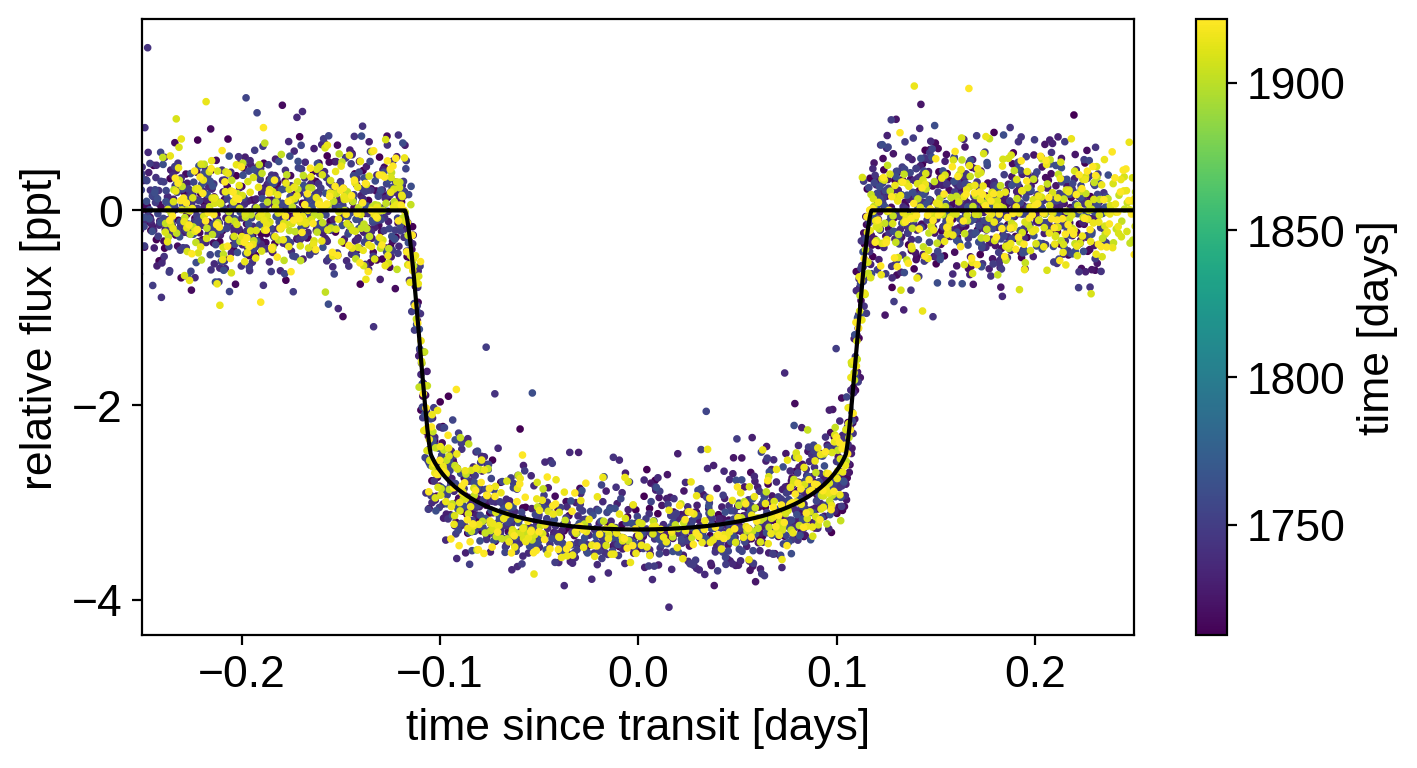

In [7]:
with model:
    gp_pred, lc_pred = xo.eval_in_model([gp.predict(), lc_model(x)], map_soln)

plt.figure(figsize=(8, 4))
x_fold = (x - map_soln["t0"] + 0.5 * map_soln["period"]) % map_soln[
    "period"
] - 0.5 * map_soln["period"]
inds = np.argsort(x_fold)
plt.scatter(x_fold, y - gp_pred - map_soln["mean"], c=x, s=3)
plt.plot(x_fold[inds], lc_pred[inds] - map_soln["mean"], "k")
plt.xlabel("time since transit [days]")
plt.ylabel("relative flux [ppt]")
plt.colorbar(label="time [days]")
plt.xlim(-0.25, 0.25);

That looks better!

Now on to sampling:

In [8]:
np.random.seed(286923464)
with model:
    trace = xo.sample(tune=2000, draws=2000, start=map_soln, chains=4)

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [b, log_dur, t0, log_period, log_ror, log_w0, log_Sw4, sigma, u, mean]


Sampling 4 chains, 0 divergences:   0%|          | 0/16000 [00:00<?, ?draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 21/16000 [00:00<07:48, 34.07draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 25/16000 [00:01<16:33, 16.07draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 28/16000 [00:01<15:02, 17.71draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 30/16000 [00:01<30:30,  8.73draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 32/16000 [00:02<30:36,  8.69draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 34/16000 [00:02<36:41,  7.25draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 36/16000 [00:02<33:05,  8.04draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 37/16000 [00:02<52:14,  5.09draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 40/16000 [00:03<42:16,  6.29draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 41/16000 [00:03<56:55,  4.67draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 44/16000 [00:03<47:08,  5.64draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 45/16000 [00:04<55:14,  4.81draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 47/16000 [00:04<43:11,  6.16draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 49/16000 [00:04<47:54,  5.55draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 51/16000 [00:04<40:52,  6.50draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 52/16000 [00:05<44:35,  5.96draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 53/16000 [00:05<48:01,  5.53draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 55/16000 [00:05<40:49,  6.51draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 56/16000 [00:05<53:20,  4.98draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 58/16000 [00:05<42:37,  6.23draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 59/16000 [00:06<43:22,  6.12draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 60/16000 [00:06<53:13,  4.99draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 63/16000 [00:06<40:44,  6.52draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 65/16000 [00:06<45:31,  5.83draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 67/16000 [00:07<37:22,  7.10draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 69/16000 [00:07<43:45,  6.07draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 71/16000 [00:07<38:31,  6.89draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 72/16000 [00:07<46:23,  5.72draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 73/16000 [00:08<43:13,  6.14draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 75/16000 [00:08<36:36,  7.25draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 76/16000 [00:08<49:48,  5.33draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 77/16000 [00:08<44:16,  5.99draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 79/16000 [00:08<39:14,  6.76draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 80/16000 [00:09<47:38,  5.57draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 81/16000 [00:09<45:21,  5.85draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 83/16000 [00:09<39:22,  6.74draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 84/16000 [00:09<49:01,  5.41draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 85/16000 [00:09<42:47,  6.20draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 86/16000 [00:09<39:34,  6.70draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 87/16000 [00:10<37:47,  7.02draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 88/16000 [00:10<45:14,  5.86draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 90/16000 [00:10<40:24,  6.56draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 91/16000 [00:10<42:35,  6.22draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 92/16000 [00:10<46:55,  5.65draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 93/16000 [00:11<42:22,  6.26draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 94/16000 [00:11<37:52,  7.00draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 95/16000 [00:11<34:33,  7.67draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 96/16000 [00:11<44:16,  5.99draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 97/16000 [00:11<41:41,  6.36draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 99/16000 [00:11<33:42,  7.86draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 101/16000 [00:11<32:37,  8.12draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 102/16000 [00:12<30:56,  8.56draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 103/16000 [00:12<32:50,  8.07draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 104/16000 [00:12<31:15,  8.47draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 105/16000 [00:12<42:43,  6.20draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 107/16000 [00:12<37:27,  7.07draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 108/16000 [00:12<44:03,  6.01draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 109/16000 [00:13<41:43,  6.35draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 110/16000 [00:13<38:40,  6.85draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 111/16000 [00:13<38:44,  6.83draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 112/16000 [00:13<40:18,  6.57draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 113/16000 [00:13<36:32,  7.25draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 114/16000 [00:13<39:04,  6.78draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 115/16000 [00:13<41:39,  6.35draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 116/16000 [00:14<39:19,  6.73draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 118/16000 [00:14<38:47,  6.82draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 119/16000 [00:14<41:39,  6.35draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 120/16000 [00:14<39:12,  6.75draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 122/16000 [00:15<39:35,  6.68draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 123/16000 [00:15<38:48,  6.82draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 124/16000 [00:15<38:00,  6.96draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 126/16000 [00:15<38:44,  6.83draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 127/16000 [00:15<37:19,  7.09draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 128/16000 [00:15<38:27,  6.88draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 130/16000 [00:16<40:20,  6.56draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 131/16000 [00:16<36:52,  7.17draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 132/16000 [00:16<34:10,  7.74draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 134/16000 [00:16<39:34,  6.68draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 136/16000 [00:17<35:55,  7.36draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 138/16000 [00:17<39:41,  6.66draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 139/16000 [00:17<38:32,  6.86draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 141/16000 [00:17<35:17,  7.49draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 142/16000 [00:17<44:02,  6.00draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 143/16000 [00:18<42:56,  6.16draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 145/16000 [00:18<39:14,  6.73draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 146/16000 [00:18<46:29,  5.68draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 147/16000 [00:18<43:32,  6.07draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 149/16000 [00:18<38:26,  6.87draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 150/16000 [00:19<44:02,  6.00draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 151/16000 [00:19<44:39,  5.91draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 153/16000 [00:19<40:31,  6.52draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 154/16000 [00:19<39:11,  6.74draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 155/16000 [00:19<44:26,  5.94draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 157/16000 [00:20<41:16,  6.40draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 158/16000 [00:20<37:27,  7.05draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 159/16000 [00:20<42:51,  6.16draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 161/16000 [00:20<43:20,  6.09draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 163/16000 [00:21<40:03,  6.59draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 165/16000 [00:21<41:30,  6.36draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 167/16000 [00:21<38:17,  6.89draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 168/16000 [00:21<35:20,  7.47draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 169/16000 [00:22<45:34,  5.79draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 171/16000 [00:22<39:09,  6.74draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 172/16000 [00:22<41:37,  6.34draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 173/16000 [00:22<51:35,  5.11draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 175/16000 [00:22<42:03,  6.27draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 176/16000 [00:23<46:10,  5.71draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 177/16000 [00:23<49:41,  5.31draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 180/16000 [00:23<38:26,  6.86draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 182/16000 [00:23<44:16,  5.95draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 184/16000 [00:23<36:50,  7.15draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 186/16000 [00:24<44:34,  5.91draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 188/16000 [00:24<35:10,  7.49draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 190/16000 [00:24<35:53,  7.34draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 192/16000 [00:25<38:13,  6.89draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 194/16000 [00:25<36:44,  7.17draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 195/16000 [00:25<43:43,  6.03draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 196/16000 [00:25<41:20,  6.37draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 199/16000 [00:26<35:04,  7.51draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 200/16000 [00:26<45:47,  5.75draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 202/16000 [00:26<37:18,  7.06draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 204/16000 [00:26<31:32,  8.35draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 206/16000 [00:26<34:05,  7.72draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 208/16000 [00:27<31:00,  8.49draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 211/16000 [00:27<32:44,  8.04draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 212/16000 [00:27<36:27,  7.22draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 216/16000 [00:28<33:54,  7.76draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 217/16000 [00:28<34:30,  7.62draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 220/16000 [00:28<36:42,  7.16draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 223/16000 [00:28<31:22,  8.38draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 224/16000 [00:29<53:31,  4.91draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 226/16000 [00:29<41:25,  6.35draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 228/16000 [00:29<33:06,  7.94draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 230/16000 [00:29<39:47,  6.61draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 232/16000 [00:30<36:33,  7.19draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 234/16000 [00:30<40:55,  6.42draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 236/16000 [00:30<38:22,  6.85draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 237/16000 [00:31<45:04,  5.83draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 239/16000 [00:31<36:57,  7.11draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 240/16000 [00:31<40:09,  6.54draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 241/16000 [00:31<51:43,  5.08draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 244/16000 [00:31<39:10,  6.70draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 246/16000 [00:32<46:39,  5.63draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 248/16000 [00:32<36:40,  7.16draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 250/16000 [00:32<30:27,  8.62draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 253/16000 [00:32<28:52,  9.09draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 255/16000 [00:33<33:06,  7.93draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 258/16000 [00:33<26:34,  9.87draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 261/16000 [00:33<21:37, 12.13draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 263/16000 [00:33<19:33, 13.41draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 265/16000 [00:33<20:04, 13.06draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 267/16000 [00:33<18:24, 14.25draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 271/16000 [00:33<15:12, 17.24draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 274/16000 [00:34<24:20, 10.76draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 278/16000 [00:34<20:01, 13.08draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 281/16000 [00:34<16:41, 15.70draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 284/16000 [00:34<18:58, 13.80draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 286/16000 [00:35<21:29, 12.19draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 288/16000 [00:35<20:04, 13.04draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 291/16000 [00:35<16:48, 15.58draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 295/16000 [00:35<13:47, 18.98draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 299/16000 [00:35<12:01, 21.75draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 305/16000 [00:35<09:47, 26.70draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 309/16000 [00:35<09:24, 27.80draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 315/16000 [00:35<08:12, 31.84draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 322/16000 [00:36<07:01, 37.15draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 327/16000 [00:36<06:42, 38.92draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 333/16000 [00:36<06:02, 43.23draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 338/16000 [00:36<06:05, 42.86draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 347/16000 [00:36<05:08, 50.74draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 357/16000 [00:36<04:34, 57.08draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 364/16000 [00:36<04:27, 58.54draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 371/16000 [00:36<04:16, 60.98draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 378/16000 [00:37<05:29, 47.44draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 385/16000 [00:37<05:01, 51.85draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 393/16000 [00:37<04:37, 56.14draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 403/16000 [00:37<04:01, 64.55draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 411/16000 [00:37<04:05, 63.60draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 418/16000 [00:37<03:59, 65.03draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 426/16000 [00:37<03:53, 66.62draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 433/16000 [00:37<04:03, 63.88draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 440/16000 [00:37<03:59, 65.09draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 450/16000 [00:38<03:34, 72.53draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 463/16000 [00:38<03:09, 82.12draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 473/16000 [00:38<03:09, 81.85draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 482/16000 [00:38<03:05, 83.87draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 491/16000 [00:38<03:02, 84.86draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 500/16000 [00:38<03:05, 83.48draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 515/16000 [00:38<02:41, 95.65draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 526/16000 [00:38<02:54, 88.64draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 536/16000 [00:38<02:55, 88.11draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 550/16000 [00:39<02:39, 96.98draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 567/16000 [00:39<02:21, 108.88draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 586/16000 [00:39<02:05, 122.58draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 604/16000 [00:39<01:55, 133.39draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 619/16000 [00:39<01:57, 130.98draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 633/16000 [00:39<01:59, 128.18draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 647/16000 [00:39<01:57, 131.10draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 661/16000 [00:39<02:01, 126.50draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 674/16000 [00:39<02:13, 114.51draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 686/16000 [00:40<02:25, 105.25draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 701/16000 [00:40<02:14, 113.42draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 713/16000 [00:40<02:13, 114.33draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 725/16000 [00:40<02:19, 109.68draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 737/16000 [00:40<02:15, 112.50draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 751/16000 [00:40<02:12, 114.74draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 764/16000 [00:40<02:13, 114.48draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 776/16000 [00:40<02:15, 112.01draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 788/16000 [00:40<02:22, 106.88draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 799/16000 [00:41<02:31, 100.59draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 811/16000 [00:41<02:25, 104.35draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 822/16000 [00:41<02:23, 105.59draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 835/16000 [00:41<02:17, 110.29draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 850/16000 [00:41<02:08, 117.64draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 863/16000 [00:41<02:05, 120.43draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 880/16000 [00:41<01:59, 126.19draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 895/16000 [00:41<01:57, 128.88draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 910/16000 [00:41<01:52, 134.16draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 925/16000 [00:42<01:50, 136.99draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 939/16000 [00:42<02:03, 122.10draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 952/16000 [00:42<02:07, 118.41draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 965/16000 [00:42<02:10, 115.56draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 978/16000 [00:42<02:08, 116.61draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 990/16000 [00:42<02:17, 108.86draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1005/16000 [00:42<02:07, 118.01draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1018/16000 [00:42<02:11, 114.03draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1032/16000 [00:43<02:06, 118.30draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1045/16000 [00:43<02:11, 113.72draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1058/16000 [00:43<02:08, 116.04draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1070/16000 [00:43<02:18, 108.05draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1082/16000 [00:43<02:17, 108.16draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1095/16000 [00:43<02:19, 106.84draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1108/16000 [00:43<02:15, 110.15draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1120/16000 [00:43<02:12, 112.01draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1132/16000 [00:43<02:27, 100.50draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1143/16000 [00:44<02:41, 91.72draws/s] 

Sampling 4 chains, 0 divergences:   7%|▋         | 1155/16000 [00:44<02:33, 96.67draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1166/16000 [00:44<02:28, 99.71draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1177/16000 [00:44<02:24, 102.43draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1191/16000 [00:44<02:13, 111.02draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1203/16000 [00:44<02:16, 108.55draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1215/16000 [00:44<02:16, 108.01draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1226/16000 [00:44<02:28, 99.25draws/s] 

Sampling 4 chains, 0 divergences:   8%|▊         | 1237/16000 [00:45<02:41, 91.51draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1247/16000 [00:45<02:43, 90.15draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1257/16000 [00:45<02:39, 92.51draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1268/16000 [00:45<02:32, 96.36draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1278/16000 [00:45<02:40, 91.87draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1288/16000 [00:45<02:58, 82.53draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1297/16000 [00:45<02:58, 82.50draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1307/16000 [00:45<02:50, 85.99draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1319/16000 [00:45<02:38, 92.36draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1330/16000 [00:46<02:37, 93.26draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1340/16000 [00:46<02:35, 94.16draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1350/16000 [00:46<02:33, 95.17draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 1361/16000 [00:46<02:29, 98.12draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 1371/16000 [00:46<02:58, 81.91draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 1380/16000 [00:46<02:58, 81.76draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 1389/16000 [00:46<03:22, 72.15draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1402/16000 [00:46<03:07, 77.90draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1411/16000 [00:47<03:07, 77.77draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1421/16000 [00:47<03:00, 80.57draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1432/16000 [00:47<03:01, 80.11draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1445/16000 [00:47<02:49, 85.92draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1457/16000 [00:47<02:37, 92.46draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1467/16000 [00:47<02:42, 89.68draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1477/16000 [00:47<02:42, 89.39draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1488/16000 [00:47<02:34, 94.22draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1499/16000 [00:47<02:28, 97.58draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1509/16000 [00:48<02:27, 98.06draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1519/16000 [00:48<02:38, 91.46draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1529/16000 [00:48<02:36, 92.73draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1540/16000 [00:48<02:36, 92.34draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1551/16000 [00:48<02:33, 94.15draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1562/16000 [00:48<02:27, 97.67draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1573/16000 [00:48<02:30, 95.65draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1583/16000 [00:48<02:40, 90.04draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1593/16000 [00:49<02:36, 91.79draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1603/16000 [00:49<02:49, 84.85draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1612/16000 [00:49<03:00, 79.88draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1621/16000 [00:49<03:05, 77.32draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1631/16000 [00:49<02:53, 82.89draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1641/16000 [00:49<02:46, 86.26draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1650/16000 [00:49<03:19, 71.93draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1658/16000 [00:49<03:41, 64.73draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1665/16000 [00:50<04:09, 57.51draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1673/16000 [00:50<03:58, 60.17draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1684/16000 [00:50<03:28, 68.57draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1692/16000 [00:50<03:22, 70.70draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1701/16000 [00:50<03:09, 75.40draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1713/16000 [00:50<02:50, 84.00draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1723/16000 [00:50<03:01, 78.60draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1732/16000 [00:50<03:05, 76.86draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1741/16000 [00:51<03:06, 76.27draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1751/16000 [00:51<02:59, 79.40draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1762/16000 [00:51<02:49, 84.07draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1771/16000 [00:51<03:15, 72.71draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1779/16000 [00:51<03:11, 74.17draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1790/16000 [00:51<02:59, 79.21draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 1803/16000 [00:51<02:40, 88.34draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 1814/16000 [00:51<02:34, 91.94draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 1827/16000 [00:51<02:22, 99.78draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 1838/16000 [00:52<02:25, 97.41draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1850/16000 [00:52<02:19, 101.17draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1862/16000 [00:52<02:15, 104.33draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1873/16000 [00:52<02:18, 102.22draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1886/16000 [00:52<02:14, 104.60draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1899/16000 [00:52<02:12, 106.79draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1910/16000 [00:52<02:20, 100.60draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1923/16000 [00:52<02:11, 107.00draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1934/16000 [00:52<02:17, 102.54draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1945/16000 [00:53<02:15, 103.79draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1956/16000 [00:53<02:23, 97.59draws/s] 

Sampling 4 chains, 0 divergences:  12%|█▏        | 1966/16000 [00:53<02:26, 95.93draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1978/16000 [00:53<02:20, 99.86draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1989/16000 [00:53<02:27, 94.85draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1999/16000 [00:53<02:32, 92.06draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2009/16000 [00:53<02:36, 89.13draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2021/16000 [00:53<02:28, 94.07draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2033/16000 [00:53<02:18, 100.59draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2046/16000 [00:54<02:12, 105.13draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2057/16000 [00:54<02:11, 106.28draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2068/16000 [00:54<02:25, 95.70draws/s] 

Sampling 4 chains, 0 divergences:  13%|█▎        | 2079/16000 [00:54<02:20, 98.99draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2090/16000 [00:54<02:24, 96.31draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2100/16000 [00:54<02:24, 96.03draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2115/16000 [00:54<02:09, 106.98draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2127/16000 [00:54<02:09, 107.05draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2139/16000 [00:55<02:10, 105.99draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2150/16000 [00:55<02:25, 94.96draws/s] 

Sampling 4 chains, 0 divergences:  14%|█▎        | 2160/16000 [00:55<02:52, 80.06draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 2169/16000 [00:55<02:49, 81.44draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 2180/16000 [00:55<02:40, 86.32draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 2194/16000 [00:55<02:22, 96.74draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2206/16000 [00:55<02:18, 99.80draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2217/16000 [00:55<02:15, 101.41draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2229/16000 [00:55<02:11, 104.40draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2240/16000 [00:56<02:11, 104.73draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2251/16000 [00:56<02:26, 93.76draws/s] 

Sampling 4 chains, 0 divergences:  14%|█▍        | 2261/16000 [00:56<02:34, 88.85draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2272/16000 [00:56<02:28, 92.63draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2283/16000 [00:56<02:26, 93.39draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2295/16000 [00:56<02:26, 93.85draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2305/16000 [00:56<02:24, 95.05draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2315/16000 [00:56<02:34, 88.83draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2325/16000 [00:57<02:35, 88.12draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2334/16000 [00:57<02:52, 79.07draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2343/16000 [00:57<02:54, 78.38draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2353/16000 [00:57<02:44, 83.15draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2365/16000 [00:57<02:30, 90.31draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2376/16000 [00:57<02:26, 93.15draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2387/16000 [00:57<02:22, 95.76draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2397/16000 [00:57<02:22, 95.62draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2410/16000 [00:57<02:14, 101.09draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2423/16000 [00:58<02:07, 106.35draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2434/16000 [00:58<02:22, 95.48draws/s] 

Sampling 4 chains, 0 divergences:  15%|█▌        | 2445/16000 [00:58<02:17, 98.26draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2457/16000 [00:58<02:13, 101.74draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2468/16000 [00:58<02:11, 102.54draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2479/16000 [00:58<02:18, 97.31draws/s] 

Sampling 4 chains, 0 divergences:  16%|█▌        | 2489/16000 [00:58<02:18, 97.44draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2499/16000 [00:58<02:17, 98.06draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2509/16000 [00:58<02:18, 97.61draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2519/16000 [00:59<02:20, 95.63draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2530/16000 [00:59<02:16, 98.35draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2542/16000 [00:59<02:12, 101.60draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2553/16000 [00:59<02:10, 103.11draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2567/16000 [00:59<02:02, 109.52draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2579/16000 [00:59<02:05, 106.89draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2590/16000 [00:59<02:13, 100.74draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 2601/16000 [00:59<02:18, 96.47draws/s] 

Sampling 4 chains, 0 divergences:  16%|█▋        | 2612/16000 [00:59<02:16, 97.84draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 2623/16000 [01:00<02:16, 98.32draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 2634/16000 [01:00<02:16, 98.02draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2648/16000 [01:00<02:07, 104.60draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2661/16000 [01:00<02:03, 107.60draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2674/16000 [01:00<02:01, 109.44draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2687/16000 [01:00<01:59, 111.66draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2699/16000 [01:00<02:06, 105.27draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2711/16000 [01:00<02:03, 107.67draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2722/16000 [01:00<02:04, 106.67draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2733/16000 [01:01<02:08, 103.28draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2744/16000 [01:01<02:08, 103.11draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2755/16000 [01:01<02:17, 96.00draws/s] 

Sampling 4 chains, 0 divergences:  17%|█▋        | 2765/16000 [01:01<02:18, 95.76draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2775/16000 [01:01<02:21, 93.53draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2789/16000 [01:01<02:13, 99.23draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2804/16000 [01:01<02:02, 107.36draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2816/16000 [01:01<01:59, 109.92draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2828/16000 [01:01<02:02, 107.67draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2844/16000 [01:02<01:50, 118.64draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2857/16000 [01:02<01:53, 115.49draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2869/16000 [01:02<01:58, 110.49draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2881/16000 [01:02<01:57, 111.56draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2893/16000 [01:02<01:55, 113.22draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2905/16000 [01:02<01:57, 111.42draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2917/16000 [01:02<02:13, 97.98draws/s] 

Sampling 4 chains, 0 divergences:  18%|█▊        | 2930/16000 [01:02<02:05, 104.31draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2942/16000 [01:03<02:02, 106.43draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2953/16000 [01:03<02:03, 105.74draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 2966/16000 [01:03<01:57, 110.81draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 2978/16000 [01:03<01:54, 113.31draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 2990/16000 [01:03<01:54, 113.39draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3002/16000 [01:03<01:58, 109.32draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3014/16000 [01:03<02:00, 107.49draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3026/16000 [01:03<01:57, 110.73draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3040/16000 [01:03<01:51, 115.89draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3056/16000 [01:03<01:45, 122.50draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3069/16000 [01:04<01:47, 120.09draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3082/16000 [01:04<01:54, 112.62draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3094/16000 [01:04<01:59, 107.76draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3105/16000 [01:04<02:01, 106.37draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3116/16000 [01:04<02:05, 102.75draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 3127/16000 [01:04<02:05, 102.48draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 3138/16000 [01:04<02:17, 93.43draws/s] 

Sampling 4 chains, 0 divergences:  20%|█▉        | 3148/16000 [01:04<02:23, 89.63draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 3159/16000 [01:05<02:16, 93.82draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 3174/16000 [01:05<02:01, 105.36draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 3186/16000 [01:05<02:10, 97.92draws/s] 

Sampling 4 chains, 0 divergences:  20%|█▉        | 3197/16000 [01:05<02:07, 100.75draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 3210/16000 [01:05<02:00, 106.36draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 3222/16000 [01:05<01:58, 107.53draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 3234/16000 [01:05<01:57, 108.52draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 3246/16000 [01:05<02:01, 105.14draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 3257/16000 [01:05<02:02, 104.03draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 3268/16000 [01:06<02:00, 105.62draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3283/16000 [01:06<01:50, 115.48draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3295/16000 [01:06<01:56, 109.52draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3307/16000 [01:06<01:56, 108.96draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3322/16000 [01:06<01:49, 115.46draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3334/16000 [01:06<01:58, 107.31draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3346/16000 [01:06<02:05, 101.04draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3360/16000 [01:06<01:54, 110.16draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3375/16000 [01:06<01:46, 118.18draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3388/16000 [01:07<01:47, 117.84draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 3401/16000 [01:07<01:45, 119.38draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 3415/16000 [01:07<01:40, 124.73draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 3428/16000 [01:07<01:42, 122.85draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3441/16000 [01:07<01:42, 121.96draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3455/16000 [01:07<01:38, 126.74draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3468/16000 [01:07<01:52, 111.46draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3480/16000 [01:07<02:00, 104.02draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3492/16000 [01:08<01:59, 105.05draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3508/16000 [01:08<01:47, 116.17draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3522/16000 [01:08<01:42, 121.75draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3535/16000 [01:08<01:51, 111.35draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3547/16000 [01:08<01:55, 107.53draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3559/16000 [01:08<02:03, 101.03draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3570/16000 [01:08<02:08, 96.71draws/s] 

Sampling 4 chains, 0 divergences:  22%|██▏       | 3583/16000 [01:08<02:06, 98.07draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3597/16000 [01:08<01:59, 104.14draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3611/16000 [01:09<01:50, 111.74draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3623/16000 [01:09<01:56, 106.28draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3635/16000 [01:09<01:52, 109.51draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3650/16000 [01:09<01:45, 116.92draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3662/16000 [01:09<01:49, 112.25draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3675/16000 [01:09<01:45, 116.59draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3688/16000 [01:09<01:42, 119.57draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3701/16000 [01:09<01:42, 120.36draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3714/16000 [01:09<01:44, 117.33draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3726/16000 [01:10<01:44, 117.34draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3738/16000 [01:10<01:48, 113.50draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3754/16000 [01:10<01:40, 121.34draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 3769/16000 [01:10<01:35, 127.77draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 3783/16000 [01:10<01:34, 129.36draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 3797/16000 [01:10<01:39, 122.24draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 3810/16000 [01:10<01:42, 118.81draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 3823/16000 [01:10<01:46, 114.72draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 3835/16000 [01:11<02:03, 98.63draws/s] 

Sampling 4 chains, 0 divergences:  24%|██▍       | 3846/16000 [01:11<02:03, 98.37draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 3860/16000 [01:11<01:54, 106.24draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 3872/16000 [01:11<01:52, 108.18draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 3884/16000 [01:11<01:49, 110.68draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 3898/16000 [01:11<01:44, 115.37draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 3912/16000 [01:11<01:40, 120.49draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 3927/16000 [01:11<01:34, 127.33draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 3941/16000 [01:11<01:34, 128.08draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 3955/16000 [01:11<01:32, 130.81draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 3969/16000 [01:12<01:38, 121.53draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 3982/16000 [01:12<01:42, 116.98draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 3995/16000 [01:12<01:41, 118.11draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 4007/16000 [01:12<01:43, 116.32draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 4019/16000 [01:12<01:42, 116.77draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 4031/16000 [01:12<01:43, 115.82draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 4043/16000 [01:12<01:50, 107.79draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 4058/16000 [01:12<01:42, 116.99draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 4071/16000 [01:12<01:39, 119.85draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4085/16000 [01:13<01:36, 123.73draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4098/16000 [01:13<01:35, 124.87draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4114/16000 [01:13<01:28, 133.59draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4128/16000 [01:13<01:34, 125.23draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4141/16000 [01:13<01:33, 126.40draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4155/16000 [01:13<01:34, 125.49draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4170/16000 [01:13<01:31, 128.81draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4184/16000 [01:13<01:31, 129.73draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4199/16000 [01:13<01:28, 133.17draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 4213/16000 [01:14<01:33, 126.40draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 4227/16000 [01:14<01:30, 129.44draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4241/16000 [01:14<01:30, 129.40draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4255/16000 [01:14<01:36, 121.93draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4268/16000 [01:14<01:42, 115.01draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4280/16000 [01:14<01:53, 102.81draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4291/16000 [01:14<01:52, 103.82draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4304/16000 [01:14<01:50, 105.82draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4315/16000 [01:15<01:49, 106.29draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4327/16000 [01:15<01:47, 109.03draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4340/16000 [01:15<01:41, 114.50draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4352/16000 [01:15<01:43, 112.11draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4364/16000 [01:15<01:50, 105.47draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4377/16000 [01:15<01:46, 109.65draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4389/16000 [01:15<01:49, 106.00draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4400/16000 [01:15<01:49, 105.92draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4411/16000 [01:15<01:52, 103.45draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4422/16000 [01:16<01:54, 100.70draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4433/16000 [01:16<01:54, 100.86draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4446/16000 [01:16<01:53, 101.88draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4458/16000 [01:16<01:49, 105.40draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4471/16000 [01:16<01:45, 109.79draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4483/16000 [01:16<01:45, 109.41draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4495/16000 [01:16<01:43, 110.73draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4507/16000 [01:16<01:51, 103.42draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4518/16000 [01:16<01:50, 104.18draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4529/16000 [01:17<01:53, 101.08draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4540/16000 [01:17<01:59, 95.88draws/s] 

Sampling 4 chains, 0 divergences:  28%|██▊       | 4554/16000 [01:17<01:53, 101.22draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 4566/16000 [01:17<01:48, 105.30draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 4577/16000 [01:17<01:49, 104.73draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 4588/16000 [01:17<01:50, 103.01draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 4599/16000 [01:17<01:51, 102.71draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 4610/16000 [01:17<01:51, 102.25draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 4625/16000 [01:17<01:42, 110.75draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 4638/16000 [01:18<01:42, 111.25draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 4651/16000 [01:18<01:37, 116.27draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 4669/16000 [01:18<01:28, 128.54draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 4683/16000 [01:18<01:27, 129.53draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 4697/16000 [01:18<01:25, 132.21draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 4711/16000 [01:18<01:24, 133.21draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 4725/16000 [01:18<01:31, 122.65draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 4738/16000 [01:18<01:31, 122.98draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 4751/16000 [01:18<01:39, 112.79draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 4763/16000 [01:19<01:45, 106.59draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 4776/16000 [01:19<01:45, 106.76draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 4793/16000 [01:19<01:34, 118.06draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 4806/16000 [01:19<01:35, 117.10draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 4819/16000 [01:19<01:33, 119.19draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 4832/16000 [01:19<01:38, 113.27draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 4847/16000 [01:19<01:32, 120.14draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 4861/16000 [01:19<01:31, 122.13draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 4876/16000 [01:19<01:30, 122.77draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 4889/16000 [01:20<01:33, 118.60draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 4901/16000 [01:20<01:39, 111.09draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 4915/16000 [01:20<01:34, 116.72draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 4927/16000 [01:20<01:35, 115.40draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 4939/16000 [01:20<01:34, 116.59draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 4952/16000 [01:20<01:34, 116.76draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 4967/16000 [01:20<01:31, 120.06draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 4980/16000 [01:20<01:38, 112.35draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 4994/16000 [01:21<01:33, 117.88draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 5010/16000 [01:21<01:28, 124.84draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 5024/16000 [01:21<01:26, 127.02draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 5038/16000 [01:21<01:26, 127.31draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5056/16000 [01:21<01:19, 137.61draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5071/16000 [01:21<01:22, 132.35draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5085/16000 [01:21<01:25, 127.12draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5098/16000 [01:21<01:31, 119.13draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5112/16000 [01:21<01:29, 122.17draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5125/16000 [01:22<01:27, 123.60draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5138/16000 [01:22<01:31, 118.66draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5151/16000 [01:22<01:31, 119.08draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5164/16000 [01:22<01:33, 116.04draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5176/16000 [01:22<01:34, 114.28draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5188/16000 [01:22<01:35, 113.43draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5202/16000 [01:22<01:31, 117.63draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5216/16000 [01:22<01:32, 116.96draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5229/16000 [01:22<01:30, 119.45draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5241/16000 [01:23<01:38, 108.86draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5254/16000 [01:23<01:34, 113.91draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5270/16000 [01:23<01:27, 122.03draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5283/16000 [01:23<01:28, 120.75draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5296/16000 [01:23<01:29, 120.27draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5309/16000 [01:23<01:31, 117.07draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5324/16000 [01:23<01:25, 124.92draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5337/16000 [01:23<01:24, 125.80draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5351/16000 [01:23<01:22, 129.64draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 5365/16000 [01:24<01:23, 126.73draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 5380/16000 [01:24<01:22, 129.39draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 5394/16000 [01:24<01:23, 127.44draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 5407/16000 [01:24<01:28, 119.72draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 5420/16000 [01:24<01:35, 110.36draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 5433/16000 [01:24<01:33, 112.91draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 5445/16000 [01:24<01:39, 106.31draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 5456/16000 [01:24<01:40, 105.41draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 5468/16000 [01:24<01:36, 109.13draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 5481/16000 [01:25<01:31, 114.48draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 5493/16000 [01:25<01:30, 115.94draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 5505/16000 [01:25<01:33, 112.77draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 5517/16000 [01:25<01:46, 98.51draws/s] 

Sampling 4 chains, 0 divergences:  35%|███▍      | 5529/16000 [01:25<01:41, 102.80draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 5543/16000 [01:25<01:34, 111.03draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 5555/16000 [01:25<01:40, 104.40draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 5567/16000 [01:25<01:37, 106.89draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 5578/16000 [01:25<01:42, 102.10draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 5592/16000 [01:26<01:37, 107.06draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 5603/16000 [01:26<01:36, 107.90draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 5615/16000 [01:26<01:36, 107.46draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 5626/16000 [01:26<01:36, 107.16draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 5640/16000 [01:26<01:31, 113.28draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 5655/16000 [01:26<01:26, 119.37draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 5669/16000 [01:26<01:25, 120.41draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 5682/16000 [01:26<01:24, 121.78draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 5695/16000 [01:26<01:24, 121.58draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 5710/16000 [01:27<01:22, 125.49draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 5723/16000 [01:27<01:22, 124.14draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 5736/16000 [01:27<01:29, 114.79draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 5748/16000 [01:27<01:29, 113.96draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 5760/16000 [01:27<01:30, 113.77draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 5772/16000 [01:27<01:34, 108.58draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 5783/16000 [01:27<01:35, 107.06draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 5795/16000 [01:27<01:33, 109.13draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 5807/16000 [01:27<01:31, 110.80draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 5822/16000 [01:28<01:25, 118.92draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 5838/16000 [01:28<01:19, 127.62draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5855/16000 [01:28<01:14, 136.63draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5872/16000 [01:28<01:09, 144.93draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5887/16000 [01:28<01:13, 136.85draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5902/16000 [01:28<01:13, 136.60draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5918/16000 [01:28<01:12, 139.45draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5934/16000 [01:28<01:10, 143.74draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5949/16000 [01:28<01:09, 144.03draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5964/16000 [01:29<01:10, 141.50draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5979/16000 [01:29<01:13, 135.60draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5993/16000 [01:29<01:20, 124.99draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6007/16000 [01:29<01:21, 122.58draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6022/16000 [01:29<01:19, 125.86draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6037/16000 [01:29<01:17, 128.48draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6050/16000 [01:29<01:21, 121.35draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6063/16000 [01:29<01:20, 123.26draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6077/16000 [01:29<01:19, 124.20draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6090/16000 [01:30<01:22, 120.72draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6104/16000 [01:30<01:19, 124.25draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6121/16000 [01:30<01:13, 134.73draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6135/16000 [01:30<01:13, 134.60draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6152/16000 [01:30<01:09, 141.41draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 6167/16000 [01:30<01:08, 143.15draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 6184/16000 [01:30<01:05, 149.82draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 6200/16000 [01:30<01:05, 149.61draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 6216/16000 [01:30<01:07, 145.12draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 6231/16000 [01:31<01:10, 138.00draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 6245/16000 [01:31<01:11, 136.92draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 6259/16000 [01:31<01:11, 136.08draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 6274/16000 [01:31<01:10, 137.68draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 6290/16000 [01:31<01:07, 143.48draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 6306/16000 [01:31<01:05, 147.77draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 6322/16000 [01:31<01:04, 150.85draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 6338/16000 [01:31<01:08, 141.60draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 6353/16000 [01:31<01:12, 132.28draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 6367/16000 [01:32<01:12, 133.05draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 6381/16000 [01:32<01:13, 130.09draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 6395/16000 [01:32<01:16, 125.33draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 6409/16000 [01:32<01:14, 128.70draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 6422/16000 [01:32<01:15, 126.24draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 6435/16000 [01:32<01:17, 123.61draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 6448/16000 [01:32<01:17, 122.48draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 6463/16000 [01:32<01:14, 127.90draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 6478/16000 [01:32<01:11, 133.80draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 6492/16000 [01:33<01:11, 132.19draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 6506/16000 [01:33<01:10, 133.81draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 6520/16000 [01:33<01:13, 128.58draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 6534/16000 [01:33<01:12, 131.12draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 6548/16000 [01:33<01:11, 132.75draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 6562/16000 [01:33<01:13, 129.19draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 6579/16000 [01:33<01:08, 137.30draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 6593/16000 [01:33<01:08, 137.82draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 6608/16000 [01:33<01:08, 137.37draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 6622/16000 [01:33<01:15, 123.82draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 6635/16000 [01:34<01:22, 113.18draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6647/16000 [01:34<01:26, 108.01draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6661/16000 [01:34<01:24, 110.49draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6673/16000 [01:34<01:27, 107.02draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6684/16000 [01:34<01:26, 107.43draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6695/16000 [01:34<01:38, 94.82draws/s] 

Sampling 4 chains, 0 divergences:  42%|████▏     | 6708/16000 [01:34<01:31, 101.30draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6720/16000 [01:34<01:27, 106.26draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6735/16000 [01:35<01:20, 114.89draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6747/16000 [01:35<01:22, 112.68draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6759/16000 [01:35<01:29, 103.26draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6770/16000 [01:35<01:32, 99.75draws/s] 

Sampling 4 chains, 0 divergences:  42%|████▏     | 6784/16000 [01:35<01:24, 108.50draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6796/16000 [01:35<01:23, 110.89draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6811/16000 [01:35<01:17, 118.96draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6824/16000 [01:35<01:15, 121.11draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6840/16000 [01:35<01:10, 129.46draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6855/16000 [01:36<01:08, 134.41draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6869/16000 [01:36<01:12, 126.79draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6882/16000 [01:36<01:12, 126.40draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6896/16000 [01:36<01:12, 125.03draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6911/16000 [01:36<01:09, 130.91draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6928/16000 [01:36<01:05, 138.87draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6943/16000 [01:36<01:04, 140.15draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 6964/16000 [01:36<00:58, 155.26draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 6981/16000 [01:36<01:02, 145.32draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 6997/16000 [01:37<01:08, 131.22draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7011/16000 [01:37<01:12, 123.41draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7025/16000 [01:37<01:10, 126.85draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7040/16000 [01:37<01:07, 131.87draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7054/16000 [01:37<01:07, 133.28draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7070/16000 [01:37<01:03, 139.99draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7085/16000 [01:37<01:02, 141.55draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7100/16000 [01:37<01:02, 141.49draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7115/16000 [01:37<01:03, 139.62draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 7131/16000 [01:38<01:01, 144.38draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 7146/16000 [01:38<01:03, 140.44draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 7161/16000 [01:38<01:05, 135.61draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 7175/16000 [01:38<01:04, 136.77draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 7190/16000 [01:38<01:04, 137.21draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 7205/16000 [01:38<01:05, 134.12draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 7221/16000 [01:38<01:03, 137.39draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 7236/16000 [01:38<01:02, 139.44draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 7250/16000 [01:38<01:02, 139.20draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 7265/16000 [01:39<01:02, 139.97draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 7280/16000 [01:39<01:03, 138.21draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 7294/16000 [01:39<01:05, 132.94draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 7310/16000 [01:39<01:02, 138.94draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 7325/16000 [01:39<01:06, 131.25draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 7340/16000 [01:39<01:06, 129.30draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 7355/16000 [01:39<01:05, 131.53draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 7370/16000 [01:39<01:03, 135.08draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 7384/16000 [01:39<01:04, 133.28draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 7399/16000 [01:40<01:03, 134.52draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 7414/16000 [01:40<01:02, 138.35draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 7431/16000 [01:40<00:58, 145.44draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 7446/16000 [01:40<01:00, 140.61draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 7461/16000 [01:40<01:02, 136.59draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 7476/16000 [01:40<01:00, 140.15draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 7491/16000 [01:40<01:00, 141.56draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 7506/16000 [01:40<00:59, 142.22draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 7522/16000 [01:40<00:57, 146.84draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 7537/16000 [01:41<00:59, 141.33draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 7552/16000 [01:41<00:58, 143.32draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 7567/16000 [01:41<00:59, 142.05draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 7582/16000 [01:41<00:59, 142.24draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 7597/16000 [01:41<01:01, 137.00draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 7611/16000 [01:41<01:02, 134.59draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 7625/16000 [01:41<01:05, 128.73draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 7638/16000 [01:41<01:05, 128.11draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 7653/16000 [01:41<01:03, 131.46draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 7667/16000 [01:41<01:04, 129.35draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 7682/16000 [01:42<01:03, 130.44draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 7698/16000 [01:42<01:00, 136.51draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 7712/16000 [01:42<01:00, 136.25draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 7726/16000 [01:42<01:01, 134.40draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 7742/16000 [01:42<00:59, 139.50draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 7758/16000 [01:42<00:58, 141.51draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 7773/16000 [01:42<00:57, 142.55draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 7788/16000 [01:42<01:01, 132.84draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 7802/16000 [01:42<01:03, 129.80draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 7816/16000 [01:43<01:04, 127.28draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 7832/16000 [01:43<01:01, 132.41draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 7846/16000 [01:43<01:01, 131.63draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 7860/16000 [01:43<01:01, 131.41draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 7874/16000 [01:43<01:09, 117.75draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 7888/16000 [01:43<01:05, 122.93draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 7901/16000 [01:43<01:10, 114.72draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 7913/16000 [01:43<01:10, 114.77draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 7925/16000 [01:44<01:09, 115.71draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 7937/16000 [01:44<01:12, 111.96draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 7951/16000 [01:44<01:07, 118.84draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 7966/16000 [01:44<01:03, 126.15draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 7985/16000 [01:44<00:57, 139.85draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 8000/16000 [01:44<01:04, 124.33draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 8014/16000 [01:44<01:04, 124.21draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 8027/16000 [01:44<01:04, 124.06draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 8040/16000 [01:44<01:05, 120.85draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 8053/16000 [01:45<01:04, 122.36draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 8066/16000 [01:45<01:06, 118.52draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 8079/16000 [01:45<01:08, 116.12draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 8093/16000 [01:45<01:05, 121.34draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 8106/16000 [01:45<01:06, 118.11draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 8120/16000 [01:45<01:04, 122.99draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 8135/16000 [01:45<01:01, 128.69draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 8149/16000 [01:45<01:00, 130.82draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 8163/16000 [01:45<01:01, 127.10draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 8176/16000 [01:45<01:01, 127.36draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 8190/16000 [01:46<01:00, 129.96draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 8204/16000 [01:46<00:59, 130.87draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 8219/16000 [01:46<00:57, 135.57draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 8233/16000 [01:46<00:57, 136.24draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 8250/16000 [01:46<00:54, 142.53draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 8265/16000 [01:46<00:55, 138.77draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 8279/16000 [01:46<00:57, 133.54draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 8293/16000 [01:46<00:59, 128.59draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 8307/16000 [01:46<00:58, 131.64draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 8322/16000 [01:47<00:57, 133.69draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 8337/16000 [01:47<00:55, 137.61draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 8352/16000 [01:47<00:55, 137.87draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 8366/16000 [01:47<00:57, 132.43draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 8380/16000 [01:47<00:59, 128.18draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 8394/16000 [01:47<00:57, 131.15draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 8408/16000 [01:47<00:58, 129.40draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 8423/16000 [01:47<00:57, 132.79draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 8437/16000 [01:47<00:56, 134.62draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 8452/16000 [01:48<00:56, 134.17draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 8468/16000 [01:48<00:54, 138.24draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 8484/16000 [01:48<00:54, 137.57draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 8501/16000 [01:48<00:53, 139.50draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 8518/16000 [01:48<00:53, 140.02draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 8533/16000 [01:48<00:53, 140.49draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 8548/16000 [01:48<00:56, 131.63draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 8562/16000 [01:48<00:58, 127.74draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 8576/16000 [01:48<00:57, 129.10draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 8590/16000 [01:49<00:58, 126.52draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 8604/16000 [01:49<00:57, 129.69draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 8618/16000 [01:49<00:56, 130.95draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 8633/16000 [01:49<00:55, 132.08draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 8647/16000 [01:49<00:54, 133.81draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 8661/16000 [01:49<00:54, 133.78draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 8675/16000 [01:49<00:54, 135.06draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 8690/16000 [01:49<00:54, 133.85draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 8705/16000 [01:49<00:54, 134.97draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 8720/16000 [01:50<00:52, 138.94draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 8734/16000 [01:50<00:54, 134.30draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 8749/16000 [01:50<00:52, 137.24draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 8763/16000 [01:50<00:52, 137.82draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 8778/16000 [01:50<00:53, 135.10draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 8793/16000 [01:50<00:52, 138.18draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 8807/16000 [01:50<00:52, 137.63draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 8822/16000 [01:50<00:51, 140.18draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 8837/16000 [01:50<00:51, 138.26draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 8852/16000 [01:50<00:50, 140.62draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 8867/16000 [01:51<00:50, 142.42draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 8882/16000 [01:51<00:53, 132.70draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 8896/16000 [01:51<00:52, 134.71draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 8910/16000 [01:51<00:52, 135.70draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 8925/16000 [01:51<00:50, 138.87draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 8939/16000 [01:51<00:50, 138.73draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 8955/16000 [01:51<00:51, 138.06draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 8970/16000 [01:51<00:51, 135.40draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 8984/16000 [01:51<00:51, 136.71draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 8998/16000 [01:52<00:52, 132.87draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 9013/16000 [01:52<00:50, 137.12draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 9027/16000 [01:52<00:52, 133.81draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 9041/16000 [01:52<00:52, 131.64draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 9055/16000 [01:52<00:51, 133.73draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 9069/16000 [01:52<00:53, 129.05draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 9083/16000 [01:52<00:53, 129.51draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 9096/16000 [01:52<00:54, 125.99draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 9109/16000 [01:52<00:56, 121.28draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 9122/16000 [01:53<00:56, 121.15draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 9138/16000 [01:53<00:53, 129.14draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 9152/16000 [01:53<00:52, 129.76draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 9166/16000 [01:53<00:52, 130.83draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 9180/16000 [01:53<00:52, 129.54draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 9196/16000 [01:53<00:51, 131.46draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 9212/16000 [01:53<00:49, 136.18draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 9228/16000 [01:53<00:48, 138.83draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 9243/16000 [01:53<00:47, 141.13draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 9258/16000 [01:54<00:48, 139.82draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 9273/16000 [01:54<00:49, 135.93draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 9287/16000 [01:54<00:51, 130.89draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 9301/16000 [01:54<00:52, 127.31draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 9315/16000 [01:54<00:51, 129.86draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 9329/16000 [01:54<00:50, 131.00draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 9343/16000 [01:54<00:51, 130.27draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 9359/16000 [01:54<00:50, 132.21draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 9373/16000 [01:54<00:49, 133.38draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 9387/16000 [01:55<00:49, 132.56draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 9402/16000 [01:55<00:48, 136.54draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 9416/16000 [01:55<00:51, 127.93draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 9429/16000 [01:55<00:52, 125.54draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 9444/16000 [01:55<00:49, 131.38draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 9458/16000 [01:55<00:49, 133.28draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 9473/16000 [01:55<00:47, 136.76draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 9487/16000 [01:55<00:48, 133.26draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 9502/16000 [01:55<00:47, 135.52draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 9517/16000 [01:55<00:48, 134.95draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 9531/16000 [01:56<00:47, 135.36draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 9545/16000 [01:56<00:48, 133.45draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 9559/16000 [01:56<00:49, 129.53draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 9574/16000 [01:56<00:48, 132.47draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 9593/16000 [01:56<00:45, 140.17draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 9609/16000 [01:56<00:44, 143.69draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 9624/16000 [01:56<00:45, 140.87draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 9639/16000 [01:56<00:46, 137.63draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 9653/16000 [01:56<00:46, 136.96draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 9667/16000 [01:57<00:47, 132.54draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 9681/16000 [01:57<00:47, 134.43draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 9695/16000 [01:57<00:47, 134.03draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 9709/16000 [01:57<00:47, 133.44draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 9723/16000 [01:57<00:46, 135.03draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 9739/16000 [01:57<00:45, 139.00draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 9753/16000 [01:57<00:45, 138.71draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 9767/16000 [01:57<00:46, 134.68draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 9781/16000 [01:57<00:46, 133.20draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 9795/16000 [01:58<00:46, 133.13draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 9809/16000 [01:58<00:45, 135.04draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 9823/16000 [01:58<00:47, 129.33draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 9837/16000 [01:58<00:47, 130.39draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 9851/16000 [01:58<00:47, 129.67draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 9865/16000 [01:58<00:47, 129.20draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 9879/16000 [01:58<00:47, 130.02draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 9893/16000 [01:58<00:46, 132.25draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 9907/16000 [01:58<00:47, 128.12draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 9920/16000 [01:59<00:47, 127.00draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 9934/16000 [01:59<00:47, 128.59draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 9950/16000 [01:59<00:45, 133.61draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 9964/16000 [01:59<00:44, 135.20draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 9978/16000 [01:59<00:45, 131.00draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 9993/16000 [01:59<00:44, 135.48draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 10007/16000 [01:59<00:46, 129.82draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 10021/16000 [01:59<00:47, 126.44draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 10034/16000 [01:59<00:48, 123.73draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 10047/16000 [01:59<00:47, 124.28draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 10060/16000 [02:00<00:49, 120.04draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 10076/16000 [02:00<00:46, 126.35draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 10093/16000 [02:00<00:44, 132.09draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 10107/16000 [02:00<00:44, 133.69draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 10121/16000 [02:00<00:47, 124.15draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 10134/16000 [02:00<00:49, 117.90draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 10147/16000 [02:00<00:51, 113.02draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 10159/16000 [02:00<00:52, 111.00draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 10173/16000 [02:01<00:51, 112.54draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 10190/16000 [02:01<00:48, 120.62draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 10205/16000 [02:01<00:46, 124.74draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 10222/16000 [02:01<00:42, 135.48draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 10236/16000 [02:01<00:44, 128.92draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 10250/16000 [02:01<00:45, 126.83draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 10263/16000 [02:01<00:46, 123.19draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 10276/16000 [02:01<00:45, 124.45draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 10291/16000 [02:01<00:45, 125.68draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 10305/16000 [02:02<00:44, 127.80draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 10319/16000 [02:02<00:43, 129.51draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 10333/16000 [02:02<00:43, 129.67draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 10347/16000 [02:02<00:45, 123.42draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 10363/16000 [02:02<00:42, 132.14draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 10377/16000 [02:02<00:41, 134.13draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 10393/16000 [02:02<00:40, 139.65draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 10409/16000 [02:02<00:39, 142.34draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 10424/16000 [02:02<00:40, 139.17draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 10439/16000 [02:03<00:45, 121.43draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 10452/16000 [02:03<00:47, 116.36draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 10465/16000 [02:03<00:47, 115.53draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 10477/16000 [02:03<00:48, 113.95draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 10490/16000 [02:03<00:46, 117.27draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 10504/16000 [02:03<00:47, 115.77draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 10519/16000 [02:03<00:45, 121.58draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 10534/16000 [02:03<00:44, 124.22draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 10547/16000 [02:03<00:43, 124.69draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 10560/16000 [02:04<00:43, 123.76draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 10574/16000 [02:04<00:42, 126.84draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 10587/16000 [02:04<00:45, 120.28draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 10601/16000 [02:04<00:45, 119.78draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 10617/16000 [02:04<00:41, 128.89draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 10631/16000 [02:04<00:42, 126.91draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 10646/16000 [02:04<00:40, 132.48draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 10661/16000 [02:04<00:39, 135.09draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 10675/16000 [02:04<00:39, 134.40draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 10690/16000 [02:05<00:38, 136.65draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 10704/16000 [02:05<00:38, 136.03draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 10720/16000 [02:05<00:37, 141.06draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 10735/16000 [02:05<00:38, 137.18draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 10749/16000 [02:05<00:39, 134.38draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 10764/16000 [02:05<00:37, 138.51draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 10779/16000 [02:05<00:38, 137.21draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 10793/16000 [02:05<00:38, 135.42draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 10809/16000 [02:05<00:37, 138.16draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 10823/16000 [02:06<00:38, 136.12draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 10840/16000 [02:06<00:35, 144.52draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 10855/16000 [02:06<00:36, 140.28draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 10870/16000 [02:06<00:37, 137.25draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 10885/16000 [02:06<00:36, 138.58draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 10899/16000 [02:06<00:37, 137.72draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 10915/16000 [02:06<00:35, 143.07draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 10930/16000 [02:06<00:35, 144.10draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 10945/16000 [02:06<00:35, 142.90draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 10960/16000 [02:06<00:37, 134.96draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 10974/16000 [02:07<00:37, 132.47draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 10988/16000 [02:07<00:38, 131.77draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 11002/16000 [02:07<00:37, 131.67draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 11018/16000 [02:07<00:36, 135.07draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 11033/16000 [02:07<00:35, 138.06draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 11048/16000 [02:07<00:36, 135.82draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 11066/16000 [02:07<00:35, 140.21draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 11081/16000 [02:07<00:35, 139.82draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 11096/16000 [02:07<00:34, 142.40draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 11111/16000 [02:08<00:36, 134.61draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 11125/16000 [02:08<00:35, 135.57draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 11140/16000 [02:08<00:36, 133.98draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 11154/16000 [02:08<00:35, 135.63draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 11168/16000 [02:08<00:35, 135.07draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 11182/16000 [02:08<00:36, 131.62draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 11196/16000 [02:08<00:37, 128.59draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 11211/16000 [02:08<00:35, 133.89draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 11225/16000 [02:08<00:35, 132.95draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 11239/16000 [02:09<00:35, 133.51draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 11253/16000 [02:09<00:35, 134.28draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 11267/16000 [02:09<00:36, 128.51draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 11281/16000 [02:09<00:35, 131.46draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 11295/16000 [02:09<00:35, 132.35draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 11310/16000 [02:09<00:34, 136.82draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 11324/16000 [02:09<00:34, 136.37draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 11338/16000 [02:09<00:34, 133.25draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 11352/16000 [02:09<00:34, 133.26draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 11367/16000 [02:10<00:34, 134.50draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 11381/16000 [02:10<00:33, 136.04draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 11395/16000 [02:10<00:34, 131.84draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 11409/16000 [02:10<00:34, 132.12draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 11423/16000 [02:10<00:34, 133.77draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 11437/16000 [02:10<00:35, 129.49draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 11450/16000 [02:10<00:36, 124.47draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 11465/16000 [02:10<00:36, 124.27draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 11480/16000 [02:10<00:35, 127.25draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 11495/16000 [02:11<00:35, 127.04draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 11510/16000 [02:11<00:34, 131.60draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 11525/16000 [02:11<00:32, 136.50draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 11539/16000 [02:11<00:33, 134.84draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 11554/16000 [02:11<00:32, 138.82draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 11568/16000 [02:11<00:33, 131.95draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 11582/16000 [02:11<00:34, 129.64draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 11597/16000 [02:11<00:33, 131.26draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 11613/16000 [02:11<00:32, 133.44draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 11628/16000 [02:11<00:31, 137.15draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 11642/16000 [02:12<00:31, 136.82draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 11656/16000 [02:12<00:31, 136.94draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 11670/16000 [02:12<00:31, 136.39draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 11684/16000 [02:12<00:31, 135.41draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 11698/16000 [02:12<00:32, 130.65draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 11712/16000 [02:12<00:32, 132.35draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 11726/16000 [02:12<00:31, 134.23draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 11740/16000 [02:12<00:31, 135.08draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 11755/16000 [02:12<00:30, 138.21draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 11769/16000 [02:13<00:31, 134.58draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 11783/16000 [02:13<00:31, 134.40draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 11797/16000 [02:13<00:32, 128.65draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 11811/16000 [02:13<00:32, 130.78draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 11825/16000 [02:13<00:33, 123.50draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 11838/16000 [02:13<00:33, 122.97draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 11851/16000 [02:13<00:33, 124.67draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 11866/16000 [02:13<00:31, 131.29draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 11880/16000 [02:13<00:31, 129.44draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 11896/16000 [02:14<00:30, 133.60draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 11912/16000 [02:14<00:30, 134.28draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 11926/16000 [02:14<00:31, 129.79draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 11940/16000 [02:14<00:31, 129.85draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 11954/16000 [02:14<00:31, 129.70draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 11968/16000 [02:14<00:31, 129.14draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 11983/16000 [02:14<00:30, 131.32draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 11998/16000 [02:14<00:29, 136.36draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 12013/16000 [02:14<00:28, 139.61draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 12028/16000 [02:15<00:28, 138.37draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 12042/16000 [02:15<00:28, 138.01draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 12056/16000 [02:15<00:28, 137.40draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 12070/16000 [02:15<00:29, 131.16draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 12086/16000 [02:15<00:28, 137.40draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 12100/16000 [02:15<00:28, 137.41draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 12114/16000 [02:15<00:28, 136.72draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 12128/16000 [02:15<00:28, 135.83draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 12142/16000 [02:15<00:28, 136.15draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 12156/16000 [02:15<00:28, 134.42draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 12171/16000 [02:16<00:28, 133.80draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 12185/16000 [02:16<00:29, 128.73draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 12200/16000 [02:16<00:29, 126.86draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 12216/16000 [02:16<00:29, 129.48draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 12231/16000 [02:16<00:28, 134.58draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 12245/16000 [02:16<00:27, 135.74draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 12260/16000 [02:16<00:27, 136.10draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 12276/16000 [02:16<00:27, 137.66draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 12291/16000 [02:16<00:26, 140.78draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 12306/16000 [02:17<00:26, 139.49draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 12321/16000 [02:17<00:26, 141.10draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 12336/16000 [02:17<00:25, 141.21draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 12351/16000 [02:17<00:26, 137.70draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 12366/16000 [02:17<00:26, 137.52draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 12381/16000 [02:17<00:26, 138.40draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 12395/16000 [02:17<00:27, 131.61draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 12410/16000 [02:17<00:27, 130.38draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 12425/16000 [02:17<00:26, 134.78draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 12440/16000 [02:18<00:26, 136.15draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 12456/16000 [02:18<00:25, 140.33draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 12472/16000 [02:18<00:24, 143.84draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 12487/16000 [02:18<00:25, 137.94draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 12501/16000 [02:18<00:25, 137.36draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 12515/16000 [02:18<00:26, 130.47draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 12529/16000 [02:18<00:26, 132.65draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 12543/16000 [02:18<00:27, 127.19draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 12558/16000 [02:18<00:26, 130.95draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 12572/16000 [02:19<00:25, 132.06draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 12588/16000 [02:19<00:24, 137.09draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 12602/16000 [02:19<00:24, 136.35draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 12617/16000 [02:19<00:24, 139.72draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 12633/16000 [02:19<00:24, 138.21draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 12648/16000 [02:19<00:23, 140.49draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 12663/16000 [02:19<00:23, 140.38draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 12678/16000 [02:19<00:24, 138.02draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 12693/16000 [02:19<00:23, 140.25draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 12709/16000 [02:19<00:23, 142.82draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 12724/16000 [02:20<00:22, 143.49draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 12739/16000 [02:20<00:22, 144.35draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 12754/16000 [02:20<00:23, 139.35draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 12768/16000 [02:20<00:24, 134.63draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 12782/16000 [02:20<00:24, 131.43draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 12798/16000 [02:20<00:23, 133.76draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 12813/16000 [02:20<00:23, 137.11draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 12827/16000 [02:20<00:24, 131.33draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 12841/16000 [02:20<00:23, 133.37draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 12855/16000 [02:21<00:24, 129.42draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 12870/16000 [02:21<00:23, 133.09draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 12886/16000 [02:21<00:22, 139.33draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 12901/16000 [02:21<00:23, 130.94draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 12915/16000 [02:21<00:23, 132.54draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 12930/16000 [02:21<00:22, 137.00draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 12944/16000 [02:21<00:22, 135.58draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 12959/16000 [02:21<00:22, 138.12draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 12973/16000 [02:21<00:22, 135.98draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 12989/16000 [02:22<00:22, 136.10draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 13004/16000 [02:22<00:22, 133.99draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 13020/16000 [02:22<00:22, 134.13draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 13034/16000 [02:22<00:21, 135.02draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 13049/16000 [02:22<00:21, 136.98draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 13065/16000 [02:22<00:21, 136.15draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 13081/16000 [02:22<00:21, 137.31draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 13097/16000 [02:22<00:20, 141.95draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 13112/16000 [02:22<00:20, 139.78draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 13128/16000 [02:23<00:19, 144.38draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 13143/16000 [02:23<00:20, 141.36draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 13158/16000 [02:23<00:19, 142.32draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 13173/16000 [02:23<00:20, 138.21draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 13189/16000 [02:23<00:19, 143.24draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 13204/16000 [02:23<00:19, 144.27draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 13219/16000 [02:23<00:19, 145.63draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 13234/16000 [02:23<00:19, 139.62draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 13250/16000 [02:23<00:18, 145.08draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 13265/16000 [02:24<00:19, 142.28draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 13280/16000 [02:24<00:19, 137.65draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 13294/16000 [02:24<00:20, 132.06draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 13310/16000 [02:24<00:19, 135.85draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 13325/16000 [02:24<00:19, 134.72draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 13341/16000 [02:24<00:18, 140.25draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 13356/16000 [02:24<00:20, 130.57draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 13371/16000 [02:24<00:19, 135.02draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 13385/16000 [02:24<00:19, 133.61draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 13400/16000 [02:25<00:19, 132.50draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 13414/16000 [02:25<00:19, 134.08draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 13429/16000 [02:25<00:18, 136.37draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 13443/16000 [02:25<00:18, 136.11draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 13457/16000 [02:25<00:18, 136.65draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 13471/16000 [02:25<00:18, 135.92draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 13487/16000 [02:25<00:18, 136.05draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 13503/16000 [02:25<00:17, 141.94draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 13518/16000 [02:25<00:17, 141.23draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 13533/16000 [02:26<00:17, 137.28draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 13547/16000 [02:26<00:18, 132.39draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 13561/16000 [02:26<00:19, 125.19draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 13575/16000 [02:26<00:18, 128.07draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 13589/16000 [02:26<00:18, 130.05draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 13603/16000 [02:26<00:18, 130.96draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 13617/16000 [02:26<00:18, 131.15draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 13631/16000 [02:26<00:18, 128.78draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 13644/16000 [02:26<00:18, 128.69draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 13659/16000 [02:26<00:18, 127.94draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 13675/16000 [02:27<00:17, 130.58draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 13689/16000 [02:27<00:17, 131.99draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 13703/16000 [02:27<00:17, 131.47draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 13717/16000 [02:27<00:17, 127.86draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 13730/16000 [02:27<00:18, 122.31draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 13743/16000 [02:27<00:20, 110.27draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 13755/16000 [02:27<00:20, 107.01draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 13766/16000 [02:27<00:21, 103.31draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 13777/16000 [02:28<00:22, 100.90draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 13788/16000 [02:28<00:21, 101.71draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 13799/16000 [02:28<00:22, 97.77draws/s] 

Sampling 4 chains, 0 divergences:  86%|████████▋ | 13809/16000 [02:28<00:22, 96.21draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 13819/16000 [02:28<00:23, 94.23draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 13831/16000 [02:28<00:22, 96.33draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 13842/16000 [02:28<00:22, 97.27draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 13853/16000 [02:28<00:21, 100.74draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 13864/16000 [02:28<00:21, 99.70draws/s] 

Sampling 4 chains, 0 divergences:  87%|████████▋ | 13876/16000 [02:29<00:20, 103.56draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 13887/16000 [02:29<00:20, 104.30draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 13898/16000 [02:29<00:19, 105.21draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 13909/16000 [02:29<00:20, 102.14draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 13920/16000 [02:29<00:20, 99.90draws/s] 

Sampling 4 chains, 0 divergences:  87%|████████▋ | 13931/16000 [02:29<00:20, 100.89draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 13942/16000 [02:29<00:20, 100.80draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 13953/16000 [02:29<00:19, 102.57draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 13964/16000 [02:29<00:19, 104.17draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 13975/16000 [02:30<00:19, 101.80draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 13986/16000 [02:30<00:20, 99.61draws/s] 

Sampling 4 chains, 0 divergences:  87%|████████▋ | 13996/16000 [02:30<00:20, 99.30draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 14006/16000 [02:30<00:20, 97.03draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 14018/16000 [02:30<00:20, 97.88draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 14028/16000 [02:30<00:21, 93.81draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 14039/16000 [02:30<00:20, 97.37draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 14050/16000 [02:30<00:19, 100.57draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 14061/16000 [02:30<00:19, 99.74draws/s] 

Sampling 4 chains, 0 divergences:  88%|████████▊ | 14072/16000 [02:31<00:18, 101.71draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 14083/16000 [02:31<00:19, 96.49draws/s] 

Sampling 4 chains, 0 divergences:  88%|████████▊ | 14093/16000 [02:31<00:19, 97.40draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 14103/16000 [02:31<00:19, 97.13draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 14114/16000 [02:31<00:19, 99.04draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 14125/16000 [02:31<00:19, 97.33draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 14136/16000 [02:31<00:19, 96.38draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 14148/16000 [02:31<00:18, 100.53draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 14159/16000 [02:31<00:18, 99.00draws/s] 

Sampling 4 chains, 0 divergences:  89%|████████▊ | 14170/16000 [02:32<00:18, 100.63draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 14181/16000 [02:32<00:18, 98.45draws/s] 

Sampling 4 chains, 0 divergences:  89%|████████▊ | 14191/16000 [02:32<00:18, 97.59draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 14201/16000 [02:32<00:19, 93.85draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 14211/16000 [02:32<00:18, 94.49draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 14223/16000 [02:32<00:18, 97.25draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 14235/16000 [02:32<00:17, 99.16draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 14246/16000 [02:32<00:17, 102.17draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 14257/16000 [02:32<00:18, 93.91draws/s] 

Sampling 4 chains, 0 divergences:  89%|████████▉ | 14268/16000 [02:33<00:17, 98.06draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 14278/16000 [02:33<00:17, 96.34draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 14288/16000 [02:33<00:17, 96.84draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 14298/16000 [02:33<00:17, 95.36draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 14310/16000 [02:33<00:17, 96.76draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 14322/16000 [02:33<00:17, 97.73draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 14334/16000 [02:33<00:16, 98.85draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 14346/16000 [02:33<00:16, 100.07draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 14357/16000 [02:33<00:16, 101.66draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 14368/16000 [02:34<00:16, 101.90draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 14379/16000 [02:34<00:15, 102.35draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 14390/16000 [02:34<00:15, 100.97draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 14401/16000 [02:34<00:15, 102.26draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 14412/16000 [02:34<00:15, 99.75draws/s] 

Sampling 4 chains, 0 divergences:  90%|█████████ | 14422/16000 [02:34<00:16, 98.09draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 14433/16000 [02:34<00:15, 98.73draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 14443/16000 [02:34<00:15, 98.73draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 14453/16000 [02:34<00:16, 95.63draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 14465/16000 [02:35<00:15, 97.32draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 14477/16000 [02:35<00:15, 98.84draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 14488/16000 [02:35<00:15, 96.83draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 14498/16000 [02:35<00:17, 85.89draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 14507/16000 [02:35<00:18, 82.03draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 14516/16000 [02:35<00:19, 74.40draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 14524/16000 [02:35<00:20, 72.40draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 14532/16000 [02:35<00:21, 69.45draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 14540/16000 [02:36<00:21, 69.35draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 14548/16000 [02:36<00:21, 68.89draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 14555/16000 [02:36<00:21, 65.87draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 14562/16000 [02:36<00:22, 64.22draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 14569/16000 [02:36<00:23, 60.56draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 14576/16000 [02:36<00:23, 60.28draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 14583/16000 [02:36<00:22, 62.41draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 14590/16000 [02:36<00:24, 58.67draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 14596/16000 [02:36<00:25, 56.14draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 14603/16000 [02:37<00:24, 57.26draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 14611/16000 [02:37<00:23, 59.16draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 14617/16000 [02:37<00:23, 58.16draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 14624/16000 [02:37<00:22, 60.62draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 14631/16000 [02:37<00:22, 61.79draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 14639/16000 [02:37<00:21, 63.82draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 14647/16000 [02:37<00:20, 65.22draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 14655/16000 [02:37<00:20, 65.98draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 14663/16000 [02:38<00:20, 66.43draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 14670/16000 [02:38<00:20, 64.37draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 14678/16000 [02:38<00:20, 65.47draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 14685/16000 [02:38<00:22, 59.13draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 14692/16000 [02:38<00:21, 59.50draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 14699/16000 [02:38<00:24, 53.22draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 14705/16000 [02:38<00:24, 52.62draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 14713/16000 [02:38<00:22, 56.31draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 14721/16000 [02:39<00:21, 59.32draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 14728/16000 [02:39<00:22, 57.12draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 14735/16000 [02:39<00:20, 60.46draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 14742/16000 [02:39<00:20, 61.89draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 14750/16000 [02:39<00:19, 63.34draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 14757/16000 [02:39<00:19, 62.25draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 14764/16000 [02:39<00:20, 61.59draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 14772/16000 [02:39<00:19, 63.58draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 14780/16000 [02:39<00:18, 66.19draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 14787/16000 [02:40<00:18, 64.42draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 14794/16000 [02:40<00:19, 63.26draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 14801/16000 [02:40<00:18, 63.81draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 14809/16000 [02:40<00:18, 63.76draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 14816/16000 [02:40<00:18, 62.93draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 14823/16000 [02:40<00:19, 61.67draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 14831/16000 [02:40<00:18, 63.55draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 14839/16000 [02:40<00:17, 64.92draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 14846/16000 [02:40<00:18, 63.48draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 14853/16000 [02:41<00:18, 62.59draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 14860/16000 [02:41<00:18, 62.46draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 14867/16000 [02:41<00:18, 61.56draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 14875/16000 [02:41<00:17, 63.58draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 14882/16000 [02:41<00:17, 62.66draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 14890/16000 [02:41<00:17, 64.47draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 14897/16000 [02:41<00:17, 61.64draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 14904/16000 [02:41<00:17, 62.82draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 14911/16000 [02:42<00:18, 60.13draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 14918/16000 [02:42<00:17, 62.23draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 14925/16000 [02:42<00:18, 59.48draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 14932/16000 [02:42<00:17, 59.52draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 14939/16000 [02:42<00:17, 59.63draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 14947/16000 [02:42<00:16, 62.04draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 14955/16000 [02:42<00:16, 63.84draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 14963/16000 [02:42<00:15, 64.91draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 14970/16000 [02:42<00:16, 63.43draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 14977/16000 [02:43<00:17, 58.22draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 14985/16000 [02:43<00:16, 61.17draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 14992/16000 [02:43<00:16, 60.87draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 15000/16000 [02:43<00:15, 63.12draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 15008/16000 [02:43<00:15, 64.54draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 15015/16000 [02:43<00:15, 62.72draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 15023/16000 [02:43<00:15, 63.94draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 15030/16000 [02:43<00:16, 58.16draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 15038/16000 [02:44<00:15, 60.81draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 15046/16000 [02:44<00:14, 64.05draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 15054/16000 [02:44<00:14, 65.47draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 15062/16000 [02:44<00:14, 65.73draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 15070/16000 [02:44<00:14, 66.30draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 15077/16000 [02:44<00:14, 64.28draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 15084/16000 [02:44<00:15, 58.51draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 15092/16000 [02:44<00:14, 61.18draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 15099/16000 [02:45<00:15, 59.65draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 15106/16000 [02:45<00:14, 60.43draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 15114/16000 [02:45<00:14, 62.24draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 15121/16000 [02:45<00:14, 61.66draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 15128/16000 [02:45<00:14, 61.10draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 15135/16000 [02:45<00:14, 60.80draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 15142/16000 [02:45<00:14, 60.65draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 15150/16000 [02:45<00:13, 62.91draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 15158/16000 [02:45<00:13, 64.31draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 15166/16000 [02:46<00:12, 64.88draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 15174/16000 [02:46<00:12, 65.95draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 15182/16000 [02:46<00:12, 66.68draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 15189/16000 [02:46<00:12, 64.33draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 15197/16000 [02:46<00:12, 65.17draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 15204/16000 [02:46<00:12, 62.89draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 15211/16000 [02:46<00:12, 61.69draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 15218/16000 [02:46<00:12, 61.21draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 15226/16000 [02:47<00:12, 63.05draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 15234/16000 [02:47<00:11, 64.65draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 15242/16000 [02:47<00:11, 67.72draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 15249/16000 [02:47<00:11, 68.03draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 15256/16000 [02:47<00:11, 62.52draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 15263/16000 [02:47<00:12, 57.81draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 15270/16000 [02:47<00:12, 59.12draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 15278/16000 [02:47<00:11, 61.24draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 15285/16000 [02:47<00:11, 60.30draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 15293/16000 [02:48<00:11, 62.45draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 15301/16000 [02:48<00:11, 63.46draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 15308/16000 [02:48<00:10, 63.03draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 15315/16000 [02:48<00:11, 62.04draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 15322/16000 [02:48<00:10, 64.00draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 15329/16000 [02:48<00:10, 62.56draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 15336/16000 [02:48<00:11, 58.88draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 15343/16000 [02:48<00:10, 61.39draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 15350/16000 [02:49<00:10, 62.99draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 15357/16000 [02:49<00:10, 64.28draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 15364/16000 [02:49<00:09, 65.73draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 15371/16000 [02:49<00:09, 63.99draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 15378/16000 [02:49<00:10, 61.30draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 15385/16000 [02:49<00:10, 60.46draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 15392/16000 [02:49<00:10, 59.88draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 15399/16000 [02:49<00:09, 61.40draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 15406/16000 [02:49<00:10, 54.98draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 15413/16000 [02:50<00:10, 58.13draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 15421/16000 [02:50<00:09, 60.82draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 15428/16000 [02:50<00:10, 56.34draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 15436/16000 [02:50<00:09, 59.36draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 15443/16000 [02:50<00:09, 59.53draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 15451/16000 [02:50<00:08, 61.80draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 15459/16000 [02:50<00:08, 63.60draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 15466/16000 [02:50<00:09, 57.72draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 15472/16000 [02:51<00:11, 44.27draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 15478/16000 [02:51<00:13, 38.32draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 15483/16000 [02:51<00:14, 34.58draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 15487/16000 [02:51<00:14, 34.37draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 15491/16000 [02:51<00:14, 35.53draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 15495/16000 [02:51<00:14, 34.50draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 15499/16000 [02:52<00:15, 33.33draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 15503/16000 [02:52<00:15, 31.35draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 15507/16000 [02:52<00:15, 32.18draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 15511/16000 [02:52<00:14, 32.69draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 15515/16000 [02:52<00:16, 28.96draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 15519/16000 [02:52<00:15, 30.40draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 15523/16000 [02:52<00:15, 31.48draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 15527/16000 [02:52<00:14, 32.28draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 15531/16000 [02:53<00:14, 32.61draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 15535/16000 [02:53<00:14, 32.87draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 15539/16000 [02:53<00:13, 33.41draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 15543/16000 [02:53<00:14, 31.53draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 15547/16000 [02:53<00:13, 32.37draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 15551/16000 [02:53<00:14, 30.72draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 15555/16000 [02:53<00:13, 31.84draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 15559/16000 [02:53<00:13, 32.56draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 15563/16000 [02:54<00:13, 33.14draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 15567/16000 [02:54<00:13, 32.36draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 15571/16000 [02:54<00:13, 32.88draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 15575/16000 [02:54<00:12, 33.28draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 15579/16000 [02:54<00:13, 32.34draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 15583/16000 [02:54<00:12, 32.82draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 15587/16000 [02:54<00:13, 30.58draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 15591/16000 [02:54<00:12, 31.57draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 15596/16000 [02:55<00:11, 34.21draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 15600/16000 [02:55<00:11, 33.99draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 15604/16000 [02:55<00:11, 34.01draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 15608/16000 [02:55<00:11, 34.19draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 15612/16000 [02:55<00:11, 34.27draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 15616/16000 [02:55<00:13, 28.57draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 15620/16000 [02:55<00:12, 30.03draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 15624/16000 [02:55<00:11, 32.26draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 15628/16000 [02:56<00:11, 32.80draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 15632/16000 [02:56<00:12, 29.00draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 15636/16000 [02:56<00:11, 30.41draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 15640/16000 [02:56<00:11, 31.45draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 15644/16000 [02:56<00:11, 32.14draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 15648/16000 [02:56<00:10, 32.63draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 15652/16000 [02:56<00:10, 33.10draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 15656/16000 [02:56<00:10, 33.43draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 15660/16000 [02:57<00:10, 32.65draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 15664/16000 [02:57<00:11, 29.63draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 15668/16000 [02:57<00:11, 28.76draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 15672/16000 [02:57<00:10, 29.99draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 15676/16000 [02:57<00:10, 30.94draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 15680/16000 [02:57<00:10, 29.76draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 15684/16000 [02:57<00:10, 28.97draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 15688/16000 [02:58<00:10, 30.27draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 15692/16000 [02:58<00:09, 31.28draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 15696/16000 [02:58<00:10, 28.21draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 15700/16000 [02:58<00:10, 29.75draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 15704/16000 [02:58<00:09, 30.97draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 15708/16000 [02:58<00:09, 31.83draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 15712/16000 [02:58<00:08, 32.37draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 15716/16000 [02:58<00:08, 31.88draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 15720/16000 [02:59<00:08, 32.45draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 15724/16000 [02:59<00:08, 32.97draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 15728/16000 [02:59<00:08, 33.31draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 15732/16000 [02:59<00:07, 33.56draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 15736/16000 [02:59<00:07, 33.59draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 15740/16000 [02:59<00:07, 33.70draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 15744/16000 [02:59<00:08, 31.57draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 15748/16000 [02:59<00:08, 30.23draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 15752/16000 [03:00<00:08, 30.38draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 15756/16000 [03:00<00:07, 30.99draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 15760/16000 [03:00<00:07, 31.61draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 15764/16000 [03:00<00:07, 32.04draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 15768/16000 [03:00<00:07, 32.35draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 15772/16000 [03:00<00:06, 32.80draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 15776/16000 [03:00<00:06, 33.02draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 15780/16000 [03:00<00:06, 33.10draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 15784/16000 [03:01<00:06, 31.05draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 15788/16000 [03:01<00:06, 32.90draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 15792/16000 [03:01<00:06, 33.15draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 15796/16000 [03:01<00:06, 33.36draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 15800/16000 [03:01<00:06, 31.05draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 15804/16000 [03:01<00:06, 29.90draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 15808/16000 [03:01<00:06, 31.09draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 15812/16000 [03:01<00:06, 30.60draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 15816/16000 [03:02<00:05, 31.62draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 15820/16000 [03:02<00:05, 32.15draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 15824/16000 [03:02<00:05, 32.77draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 15828/16000 [03:02<00:05, 33.25draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 15832/16000 [03:02<00:05, 33.55draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 15836/16000 [03:02<00:04, 33.80draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 15840/16000 [03:02<00:05, 31.70draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 15844/16000 [03:02<00:05, 30.40draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 15848/16000 [03:02<00:04, 32.58draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 15852/16000 [03:03<00:04, 32.92draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 15856/16000 [03:03<00:04, 33.29draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 15860/16000 [03:03<00:04, 33.46draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 15864/16000 [03:03<00:04, 33.52draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 15868/16000 [03:03<00:03, 34.86draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 15872/16000 [03:03<00:03, 32.95draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 15876/16000 [03:03<00:03, 33.24draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 15880/16000 [03:03<00:03, 33.31draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 15884/16000 [03:04<00:03, 31.17draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 15888/16000 [03:04<00:03, 32.02draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 15892/16000 [03:04<00:03, 32.65draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 15896/16000 [03:04<00:03, 33.07draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 15900/16000 [03:04<00:02, 33.42draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 15904/16000 [03:04<00:02, 33.66draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 15908/16000 [03:04<00:02, 33.71draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 15912/16000 [03:04<00:02, 33.82draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 15916/16000 [03:05<00:02, 34.03draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 15920/16000 [03:05<00:02, 31.58draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 15924/16000 [03:05<00:02, 30.23draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 15928/16000 [03:05<00:02, 31.27draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 15932/16000 [03:05<00:02, 32.00draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 15936/16000 [03:05<00:02, 30.37draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 15940/16000 [03:05<00:02, 29.41draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 15944/16000 [03:05<00:01, 30.74draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 15948/16000 [03:06<00:01, 31.61draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 15952/16000 [03:06<00:01, 30.30draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 15956/16000 [03:06<00:01, 31.43draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 15960/16000 [03:06<00:01, 32.28draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 15964/16000 [03:06<00:01, 30.74draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 15968/16000 [03:06<00:01, 31.77draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 15972/16000 [03:06<00:00, 32.52draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 15976/16000 [03:06<00:00, 30.88draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 15980/16000 [03:07<00:00, 31.75draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 15984/16000 [03:07<00:00, 33.67draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 15988/16000 [03:07<00:00, 33.91draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 15992/16000 [03:07<00:00, 34.09draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 15996/16000 [03:07<00:00, 34.20draws/s]

Sampling 4 chains, 0 divergences: 100%|██████████| 16000/16000 [03:07<00:00, 33.96draws/s]

Sampling 4 chains, 0 divergences: 100%|██████████| 16000/16000 [03:07<00:00, 85.25draws/s]

Then we can take a look at the summary statistics:

In [9]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean,0.217,0.103,0.015,0.401,0.001,0.001,6905.0,6435.0,7005.0,5079.0,1.0
log_Sw4,6.131,0.339,5.503,6.776,0.004,0.003,8900.0,8807.0,8908.0,5655.0,1.0
log_w0,2.187,0.172,1.861,2.498,0.002,0.001,8009.0,8009.0,8041.0,5592.0,1.0
log_ror,-2.913,0.007,-2.926,-2.898,0.000,0.000,6984.0,6984.0,7017.0,5499.0,1.0
log_period,1.814,0.000,1.814,1.814,0.000,0.000,9271.0,9271.0,9276.0,6378.0,1.0
t0,1712.662,0.000,1712.662,1712.662,0.000,0.000,9552.0,9552.0,9546.0,6070.0,1.0
log_dur,-1.504,0.002,-1.507,-1.500,0.000,0.000,8222.0,8221.0,8224.0,5774.0,1.0
u[0],0.173,0.076,0.029,0.309,0.001,0.001,5429.0,5429.0,4913.0,2354.0,1.0
u[1],0.252,0.104,0.063,0.447,0.001,0.001,5715.0,4661.0,5521.0,3815.0,1.0
sigma,0.159,0.008,0.145,0.173,0.000,0.000,8942.0,8942.0,8949.0,5887.0,1.0


And plot the posterior covariances compared to the values from [Pepper et al. (2019)](https://arxiv.org/abs/1911.05150):

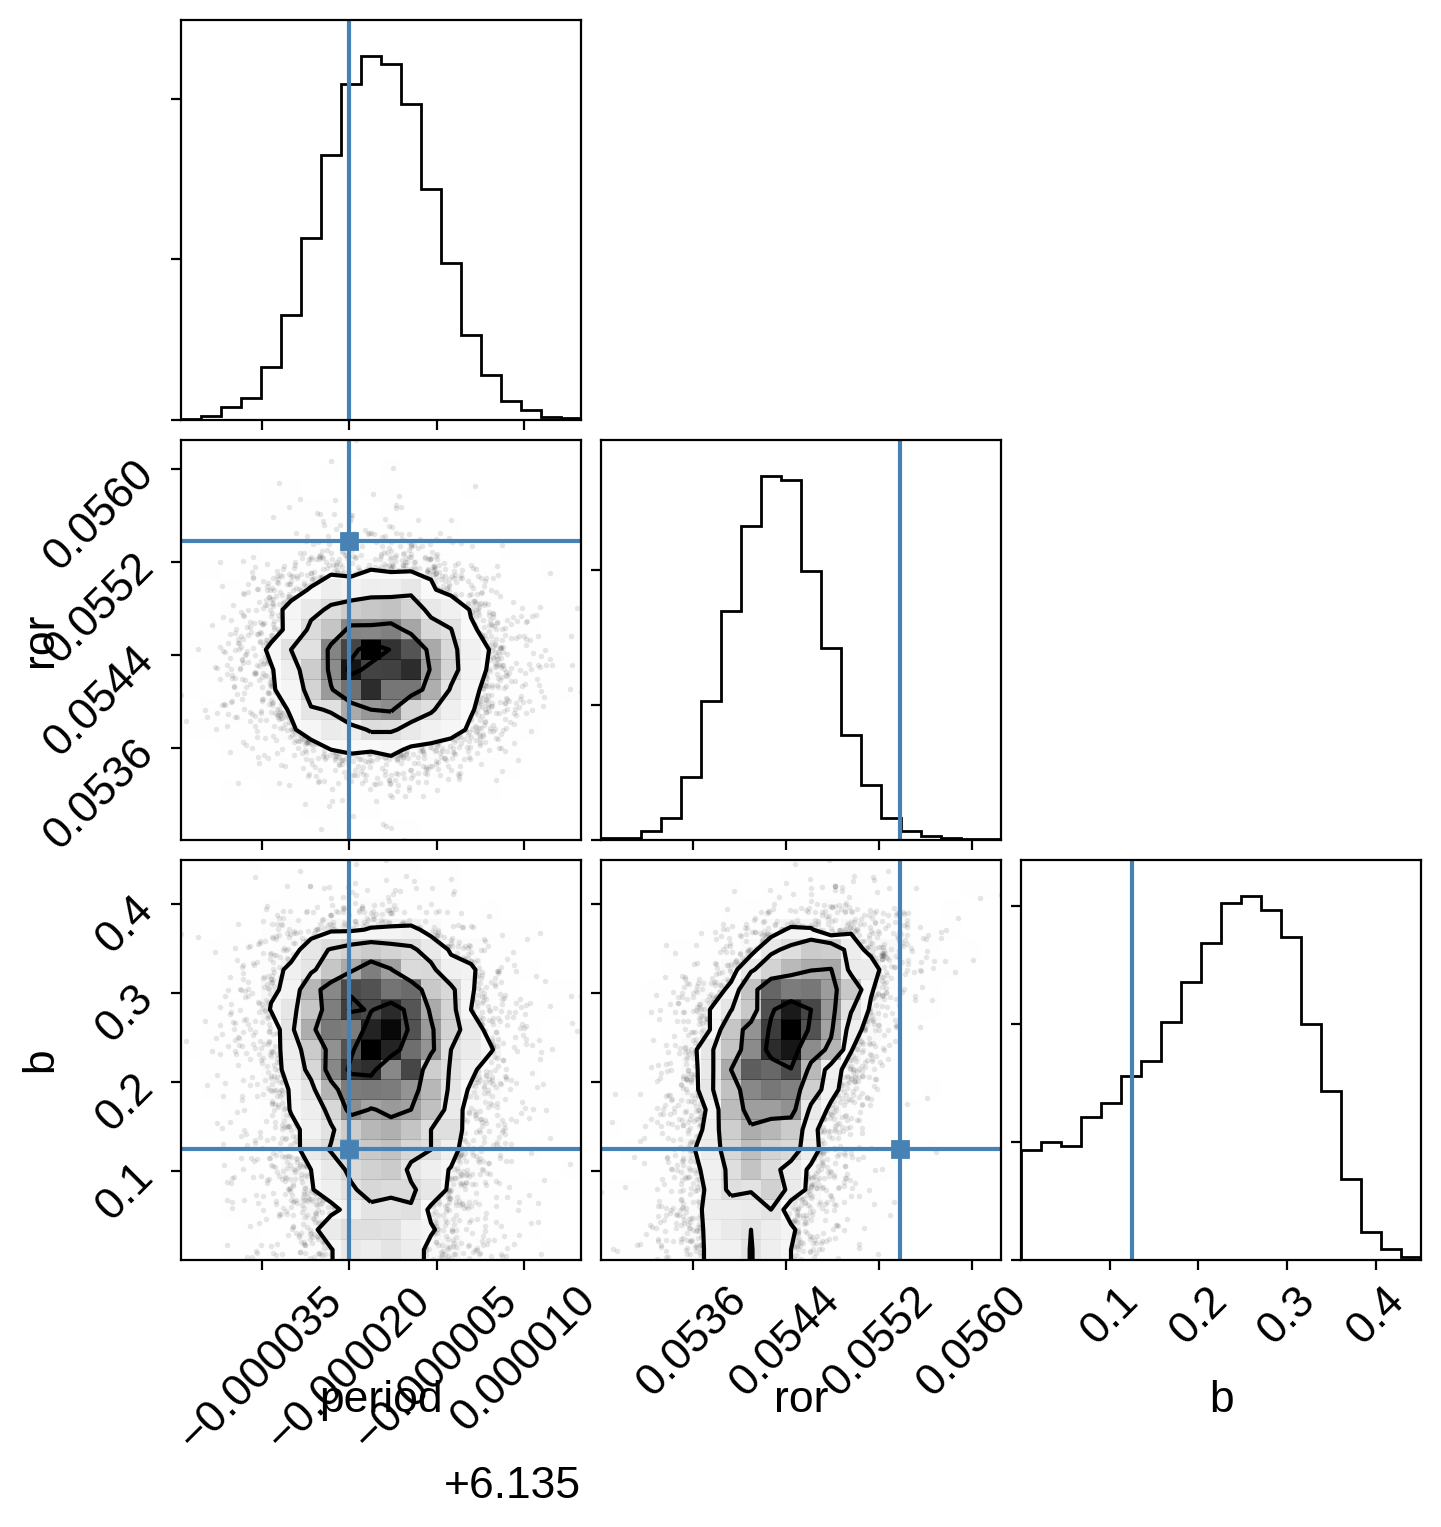

In [10]:
import corner
import astropy.units as u

samples = pm.trace_to_dataframe(trace, varnames=["period", "ror", "b"])
corner.corner(samples, truths=[6.134980, 0.05538, 0.125]);

## Bonus: eccentricity

As discussed above, we fit this model assuming a circular orbit which speeds things up for a few reasons.
First, setting eccentricity to zero means that the orbital dynamics are much simpler and more computationally efficient, since we don't need to solve Kepler's equation numerically.
But this isn't actually the main effect!
Instead the bigger issues come from the fact that the degeneracies between eccentricity, arrgument of periasteron, impact parameter, and planet radius are hard for the sampler to handle, causing the sampler's performance to plummet.
In this case, by fitting with a circular orbit where duration is one of the parameters, everything is well behaved and the sampler runs faster.

But, in this case, the planet *is* actually on an eccentric orbit, so that assumption isn't justified.
It has been recognized by various researchers over the years (I first learned about this from [Bekki Dawson](https://arxiv.org/abs/1203.5537)) that, to first order, the eccentricity mainly just changes the transit duration.
The key realization is that this can be thought of as a change in the impled density of the star.
Therefore, if you fit the transit using stellar density (or duration, in this case) as one of the parameters (*note: you must have a* different *stellar density parameter for each planet if there are more than one*), you can use an independent measurement of the stellar density to infer the eccentricity of the orbit after the fact.
All the details are described in [Dawson & Johnson (2012)](https://arxiv.org/abs/1203.5537), but here's how you can do this here using the stellar density listed in the TESS input catalog:

rho_star = 0.121689 ± 0.0281776


eccentricity = 0.45 +0.25 -0.14


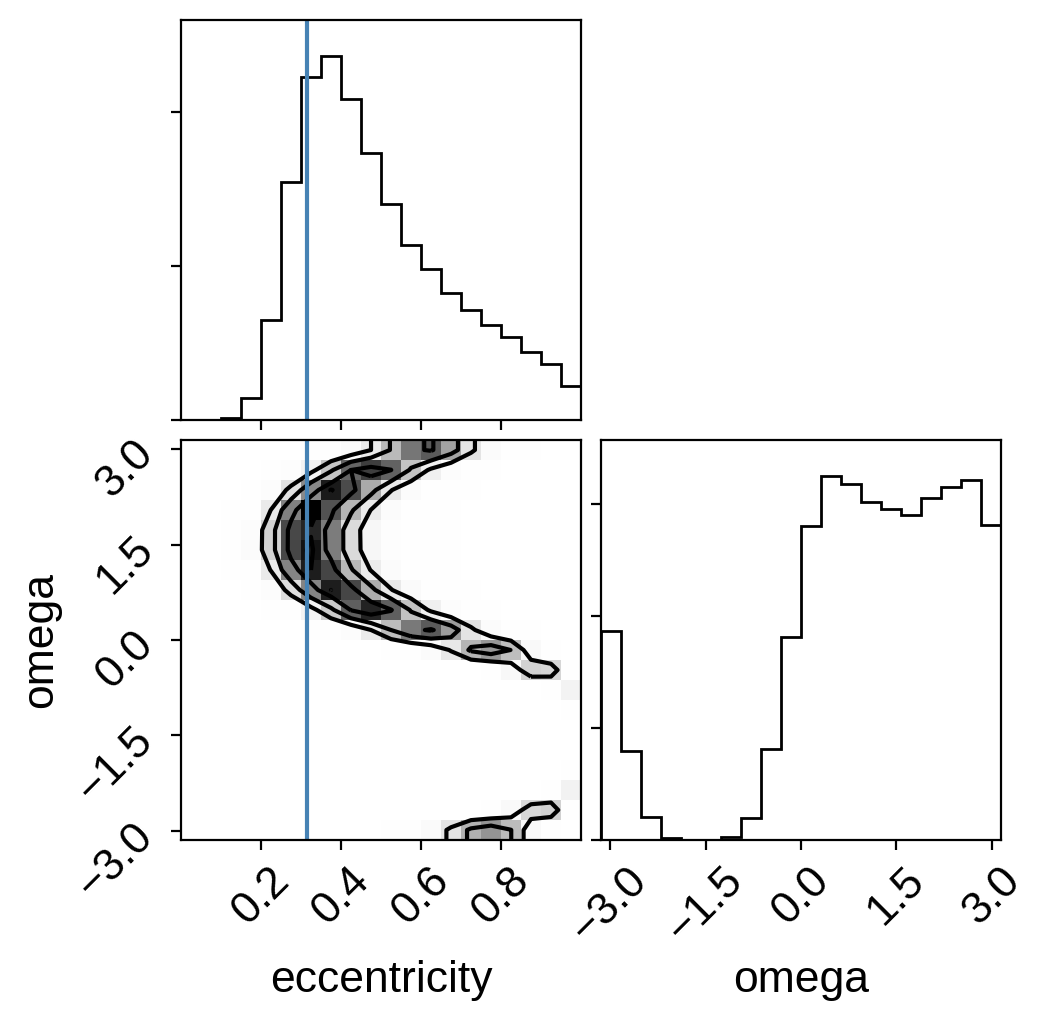

In [11]:
from astroquery.mast import Catalogs

star = Catalogs.query_object("TIC 286923464", catalog="TIC", radius=0.001)
tic_rho_star = float(star["rho"]), float(star["e_rho"])
print("rho_star = {0} ± {1}".format(*tic_rho_star))

# Extract the implied density from the fit
rho_circ = np.repeat(trace["rho_circ"], 100)

# Sample eccentricity and omega from their priors (the math might
# be a little more subtle for more informative priors, but I leave
# that as an exercise for the reader...)
ecc = np.random.uniform(0, 1, len(rho_circ))
omega = np.random.uniform(-np.pi, np.pi, len(rho_circ))

# Compute the "g" parameter from Dawson & Johnson and what true
# density that implies
g = (1 + ecc * np.sin(omega)) / np.sqrt(1 - ecc ** 2)
rho = rho_circ / g ** 3

# Re-weight these samples to get weighted posterior samples
log_weights = -0.5 * ((rho - tic_rho_star[0]) / tic_rho_star[1]) ** 2
weights = np.exp(log_weights - np.max(log_weights))

# Estimate the expected posterior quantiles
q = corner.quantile(ecc, [0.16, 0.5, 0.84], weights=weights)
print("eccentricity = {0:.2f} +{1[1]:.2f} -{1[0]:.2f}".format(q[1], np.diff(q)))

corner.corner(
    np.vstack((ecc, omega)).T,
    weights=weights,
    truths=[0.316, None],
    plot_datapoints=False,
    labels=["eccentricity", "omega"],
);

As you can see, this eccentricity estimate is consistent (albeit with large uncertainties) with the value that [Pepper et al. (2019)](https://arxiv.org/abs/1911.05150) measure using radial velocities and it is definitely clear that this planet is not on a circular orbit.

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [12]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:agol19, exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:foremanmackey17, exoplanet:foremanmackey18,
exoplanet:kipping13, exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


In [13]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Rodrigo Luger and Ian Czekala and
            Eric Agol and Adrian Price-Whelan and Tom Barclay},
   title = {exoplanet-dev/exoplanet v0.3.2},
   month = may,
    year = 2020,
     doi = {10.5281/zenodo.1998447},
     url = {https://doi.org/10.5281/zenodo.1998447}
}
...
